In [50]:
import numpy as np
from scipy.spatial.transform import Rotation as R
from scipy.signal import butter, lfilter, freqz, medfilt
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, confusion_matrix, roc_curve
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, ReLU, Add, GlobalAveragePooling1D, Dense

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [16]:
# Function to calculate magnitude of acceleration
def calculate_magnitude(row):
    return np.sqrt(row['X']**2 + row['Y']**2 + row['Z']**2)

In [ ]:
# Function to add random noise
def add_noise(df, noise_level=0.01):
    noise = np.random.normal(loc=0, scale=noise_level, size=df.shape)
    df_noisy = df + noise
    return df_noisy

# Function to perform time warping
def time_warp(df, warp_factor=0.1):
    time_steps = np.arange(df.shape[0])
    time_steps_new = np.interp(np.linspace(0, 1, df.shape[0]), np.linspace(0, 1, df.shape[0]) + np.random.uniform(-warp_factor, warp_factor, df.shape[0]), time_steps)
    df_time_warped = pd.DataFrame(np.interp(time_steps_new, time_steps, df), columns=df.columns)
    return df_time_warped

# Function to scale amplitude
def scale_amplitude(df, scale_factor_range=(0.9, 1.1)):
    scale_factor = np.random.uniform(*scale_factor_range)
    df_scaled = df * scale_factor
    return df_scaled

# Function to jitter
def jitter(df, jitter_factor=0.01):
    jitter_noise = np.random.uniform(-1, 1, df.shape) * jitter_factor
    df_jittered = df + jitter_noise
    return df_jittered

In [17]:
def load_data(path, sensors):
    cols = ['loggingTime(txt)']
    if 'accelerometer' in sensors:
        cols += ['accelerometerAccelerationX(G)', 'accelerometerAccelerationY(G)', 'accelerometerAccelerationZ(G)']
    if 'gyroscope' in sensors:
        cols += ['gyroRotationX(rad/s)', 'gyroRotationY(rad/s)', 'gyroRotationZ(rad/s)']
    # Load the data
    df = pd.read_csv(path, delimiter=',')
    df = df[cols]
    if 'accelerometer' in sensors:
        df.columns = ['time', 'X', 'Y', 'Z']
    if 'gyroscope' in sensors:
        df.columns = ['time', 'X', 'Y', 'Z', 'rotationX', 'rotationY', 'rotationZ']

    # Normalize the data
    # df['X'] = (df['X'] - df['X'].mean()) / df['X'].std()
    # df['Y'] = (df['Y'] - df['Y'].mean()) / df['Y'].std()
    # df['Z'] = (df['Z'] - df['Z'].mean()) / df['Z'].std()

    # Min max normalization
    # max = np.max([df['X'], df['Y'], df['Z']])
    # min = np.min([df['X'], df['Y'], df['Z']])
    # df['X'] = (df['X'] - min) / (max - min)
    # df['Y'] = (df['Y'] - min) / (max - min)
    # df['Z'] = (df['Z'] - min) / (max - min)

    # Calculate magnitude
    df['Magnitude'] = df.apply(calculate_magnitude, axis=1)

    # Calculate the time difference between samples
    df['time'] = pd.to_datetime(df['time'])
    
    return df

In [18]:
# Plot the data, make a bigger plot 
def plot(g):
    plt.figure(figsize=(30, 10))
    plt.plot(g['time'], g['Magnitude'], label='Magnitude')
    plt.plot(g['time'], g['X'], label='X')
    plt.plot(g['time'], g['Y'], label='Y')
    plt.plot(g['time'], g['Z'], label='Z')
    plt.legend()
    plt.show()

In [19]:
# Plot the data, make a bigger plot
def plot_shots(shots):
    for s in shots:
        plot(s)

In [20]:
# Function to find the shots in the dataframe
def find_shots(df, window_size=100, threshold=1.5, label=0):
    # Sliding window to identify shots
    shots = []
    for start in range(0, len(df) - window_size + 1):
        window = df.iloc[start:start + window_size]
        mid = window['Magnitude'].iloc[window_size//2]
        # Check that the magnitude max is in the middle of the window
        if mid == window['Magnitude'].max() and mid > threshold:
            shots.append({'time': window['time'], 'X': window['X'], 'Y': window['Y'], 'Z': window['Z'], 'Magnitude': window['Magnitude'], 'label':label})
    return shots

In [21]:
# Function to apply the butterworth filter to a sample
def butter_sample(sample, order=3, fs=50, cutoff=2):
    nyquist = 0.5 * fs
    normalized_cutoff = cutoff / nyquist
    b, a = butter(order, normalized_cutoff, btype='low', analog=False)
    sample['X'] = lfilter(b, a, sample['X'])
    sample['Y'] = lfilter(b, a, sample['Y'])
    sample['Z'] = lfilter(b, a, sample['Z']) 
    sample['Magnitude'] = calculate_magnitude(sample)
    return sample

In [22]:
def median_filter_sample(sample, kernel_size=5):
    sample['X'] = medfilt(sample['X'], kernel_size)
    sample['Y'] = medfilt(sample['Y'], kernel_size)
    sample['Z'] = medfilt(sample['Z'], kernel_size)
    sample['Magnitude'] = calculate_magnitude(sample)
    return sample

In [23]:
# Function to apply the median and butterworth filter to a list of shots
def apply_filters_shots(shots, order, fs, cutoff):
    for s in shots:
        # s = median_filter_sample(s)
        s = butter_sample(s, order, fs, cutoff)
    return shots

In [34]:
def get_shot_data(path, sensors, window_size, threshold, order, fs, cutoff, pl, label, verbose):
    df = load_data(path, sensors)
    
    if verbose:
        print('Loaded {} samples'.format(len(df)))
    all = butter_sample(df, order, fs, cutoff)
    if verbose:
        print('Preprocessed {} samples'.format(len(all)))
    shots = find_shots(df, window_size, threshold, label)
    if pl:
        plot_shots(shots)

    if verbose:
        print('Found {} shots'.format(len(shots)))
    shots = apply_filters_shots(shots, order, fs, cutoff)

    if pl:
        plot(df)
        plot_shots(shots)

    return shots

In [25]:
def construct_dataset(paths, sensors, window_size, threshold, order, fs, cutoff, pl, verbose):
    dataset = []

    for i, p in enumerate(paths):
        if verbose:
            print('Processing {}'.format(p))
        shots = get_shot_data(p, sensors, window_size, threshold, order, fs, cutoff, pl=pl, label=i, verbose=verbose)
        dataset += shots

    if verbose:
        print('Dataset size: {}'.format(len(dataset)))

    return dataset

In [26]:

def residual_block(x, filters, kernel_size=3, stride=1):
    """
    A ResNet-style residual block with 1D convolutions.
    """
    # Shortcut
    shortcut = x

    # First convolution
    x = Conv1D(filters, kernel_size=kernel_size, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Second convolution
    x = Conv1D(filters, kernel_size=kernel_size, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)

    # Add shortcut
    x = Add()([x, shortcut])

    # Final ReLU
    x = ReLU()(x)

    return x

def build_resnet(input_shape, num_classes, num_res_blocks=3):
    """
    Build a ResNet-style model with 1D convolutions.
    """
    inputs = Input(shape=input_shape)

    # Initial Conv Block
    x = Conv1D(64, kernel_size=7, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Residual Blocks
    for _ in range(num_res_blocks):
        x = residual_block(x, filters=64)

    # Classifier
    x = GlobalAveragePooling1D()(x)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    # Create model
    model = Model(inputs=inputs, outputs=outputs)

    return model

In [43]:
# Parameters

# Data parameters
sensors = ['accelerometer']  # accelerometer or gyroscope
shot_labels = ['game', 'smash', 'clear', 'drive', 'drop', 'net_drop']  # Labels for the shots
shot_labels_ix = [0, 1, 2, 3, 4, 5]  # Indexes for the labels
paths_acc = ['data/game_acc.csv', 'data/smash_acc.csv', 'data/clear_acc.csv', 'data/drive_acc.csv', 'data/drop_acc.csv', 'data/net_drop_acc.csv']
paths_gyro = ['data/game_gyro.csv', 'data/smash_gyro.csv', 'data/clear_gyro.csv', 'data/drive_gyro.csv', 'data/drop_gyro.csv', 'data/net_drop_gyro.csv']
paths_all = ['data/game_all.csv', 'data/smash_all.csv', 'data/clear_all.csv', 'data/drive_all.csv', 'data/drop_all.csv', 'data/net_drop_all.csv']
paths = [
    paths_acc[shot_labels.index("clear")], 
    # paths_acc[shot_labels.index("smash")],
    paths_acc[shot_labels.index("drive")],
    paths_acc[shot_labels.index("drop")],
    paths_acc[shot_labels.index("net_drop")],
    # paths_all[shot_labels.index("clear")],
    paths_all[shot_labels.index("smash")],
    # paths_all[shot_labels.index("drive")],
    # paths_all[shot_labels.index("drop")],
    # paths_all[shot_labels.index("net_drop")],
]

shot_labels = [
    'clear', 
    'drive', 
    'drop', 
    'net_drop', 
    'smash'
]

print(paths)
print(shot_labels)

features = ['X', 'Y', 'Z', 'Magnitude']  # Features to use for training

# Shot detection parameters
window_size = 90  # Size of the sliding window
threshold = 1.5  # Example threshold for identifying a shot, adjust as needed

# Butterworth filter parameters
order = 2 # Order of the butterworth filter
fs = 50.0 # Sample rate, Hz
cutoff = 3 # Desired cutoff frequency of the filter, Hz


dataset = construct_dataset(paths, sensors, window_size, threshold, order, fs, cutoff, pl=False, verbose=False)

['data/clear_acc.csv', 'data/drive_acc.csv', 'data/drop_acc.csv', 'data/net_drop_acc.csv', 'data/smash_all.csv']
['clear', 'drive', 'drop', 'net_drop', 'smash']


Epoch 1/25
33/33 [==============================] - 1s 4ms/step - loss: 1.3417 - accuracy: 0.4308
Epoch 2/25
33/33 [==============================] - 0s 4ms/step - loss: 0.9820 - accuracy: 0.5846
Epoch 3/25
33/33 [==============================] - 0s 4ms/step - loss: 0.8996 - accuracy: 0.6077
Epoch 4/25
33/33 [==============================] - 0s 5ms/step - loss: 0.9889 - accuracy: 0.5923
Epoch 5/25
33/33 [==============================] - 0s 5ms/step - loss: 0.9425 - accuracy: 0.6385
Epoch 6/25
33/33 [==============================] - 0s 5ms/step - loss: 0.9212 - accuracy: 0.6308
Epoch 7/25
33/33 [==============================] - 0s 5ms/step - loss: 0.7803 - accuracy: 0.6923
Epoch 8/25
33/33 [==============================] - 0s 5ms/step - loss: 0.8889 - accuracy: 0.6538
Epoch 9/25
33/33 [==============================] - 0s 5ms/step - loss: 0.8763 - accuracy: 0.6385
Epoch 10/25
33/33 [==============================] - 0s 5ms/step - loss: 0.8899 - accuracy: 0.6538
Epoch 11/25
33/33 [

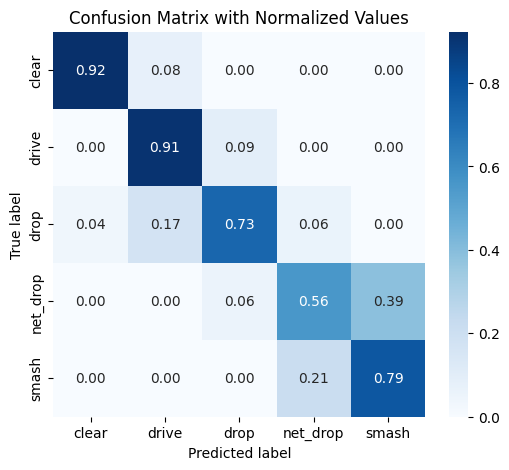

In [52]:
window_size = 90  # Size of the sliding window
threshold = 1.5  # Example threshold for identifying a shot, adjust as needed

# Butterworth filter parameters
order = 2 # Order of the butterworth filter
fs = 50.0 # Sample rate, Hz
cutoff = 3 # Desired cutoff frequency of the filter, Hz


dataset = construct_dataset(paths, sensors, window_size, threshold, order, fs, cutoff, pl=False, verbose=False)

# Build the ResNet CNN model
num_classes = len(shot_labels)  # You mentioned 6 labels for the badminton shots.
num_features = len(features)  # You mentioned 4 features for the accelerometer data.
input_shape = (window_size, num_features)


# Parameters
n_splits = 10  # Number of folds for cross-validation
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Convert the data into numpy arrays
X = np.array([[shot[feature] for shot in dataset] for feature in ['X', 'Y', 'Z', 'Magnitude']]).reshape(-1, window_size, num_features)
y = np.array([shot['label'] for shot in dataset])

# Cross-validation
accuracy_scores = []
data_test_pred_all = []
labels_test_all = []
labels_pred_all = []

for train_index, test_index in kf.split(X):
    data_train, data_test = X[train_index], X[test_index]
    labels_train, labels_test = y[train_index], y[test_index]

    # Build the model
    model = build_resnet(input_shape, num_classes)

    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    model.fit(data_train, labels_train, epochs=25, batch_size=4)

    # Evaluate the model
    loss, acc = model.evaluate(data_test, labels_test)
    accuracy_scores.append(acc)

    data_test_pred = model(data_test)
    labels_pred = np.argmax(data_test_pred, axis=1)

    labels_test_all.append(labels_test)
    data_test_pred_all.append(data_test_pred)
    labels_pred_all.append(labels_pred)

# Average accuracy across all folds
average_accuracy = sum(accuracy_scores) / n_splits
print(f'Average Test Accuracy across {n_splits} folds: {average_accuracy}')

# Convert the list of arrays into a single array
data_test_pred_all = np.concatenate(data_test_pred_all)
labels_pred_all = np.concatenate(labels_pred_all)
labels_test_all = np.concatenate(labels_test_all)

print(classification_report(labels_test_all, labels_pred_all, target_names=shot_labels))

# Generate the confusion matrix
cm = confusion_matrix(labels_test_all, labels_pred_all)

# Normalise by row sums to get the proportion of true labels per predicted label
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Convert to DataFrame for easier plotting
cm_df = pd.DataFrame(cmn, index=shot_labels, columns=shot_labels)

# Plotting the confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm_df, annot=True, fmt='.2f', cmap='Blues', xticklabels=shot_labels, yticklabels=shot_labels)
plt.title('Confusion Matrix with Normalized Values')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [44]:
# Build the ResNet CNN model

num_classes = len(shot_labels)  # You mentioned 6 labels for the badminton shots.
num_features = len(features)  # You mentioned 4 features for the accelerometer data.
input_shape = (window_size, num_features)

# Build the model
model = build_resnet(input_shape, num_classes)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 90, 4)]              0         []                            
                                                                                                  
 conv1d_21 (Conv1D)          (None, 45, 64)               1856      ['input_4[0][0]']             
                                                                                                  
 batch_normalization_21 (Ba  (None, 45, 64)               256       ['conv1d_21[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 re_lu_21 (ReLU)             (None, 45, 64)               0         ['batch_normalization_21

In [45]:
# Convert the data into numpy arrays
X = np.array([[shot[feature] for shot in dataset] for feature in ['X', 'Y', 'Z', 'Magnitude']]).reshape(-1, window_size, num_features)
y = np.array([shot['label'] for shot in dataset])

print(X.shape)
print(y.shape)

# Split the data into train+validation and test sets
data_train_val, data_test, labels_train_val, labels_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Split the train+validation set into train and validation sets
data_train, data_val, labels_train, labels_val = train_test_split(
    data_train_val, labels_train_val, test_size=0.25, random_state=42, stratify=labels_train_val)

labels_train_count = np.bincount(labels_train)/len(labels_train)
labels_val_count = np.bincount(labels_val)/len(labels_val)
labels_test_count = np.bincount(labels_test)/len(labels_test)

# # Train the model
history = model.fit(data_train, labels_train, epochs=25, batch_size=4, validation_data=(data_val, labels_val))

# Test the model
loss, acc = model.evaluate(data_test, labels_test)
print('Test Loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))

data_test_pred = model(data_test)
print(data_test_pred)
print(labels_test)
labels_pred = np.argmax(data_test_pred, axis=1)

(145, 90, 4)
(145,)
Epoch 1/25
22/22 [==============================] - 1s 13ms/step - loss: 1.3460 - accuracy: 0.3678 - val_loss: 1.2034 - val_accuracy: 0.4828
Epoch 2/25
22/22 [==============================] - 0s 5ms/step - loss: 0.9606 - accuracy: 0.5517 - val_loss: 1.0964 - val_accuracy: 0.5172
Epoch 3/25
22/22 [==============================] - 0s 5ms/step - loss: 1.1086 - accuracy: 0.5287 - val_loss: 1.0313 - val_accuracy: 0.7241
Epoch 4/25
22/22 [==============================] - 0s 5ms/step - loss: 0.8533 - accuracy: 0.6437 - val_loss: 0.9918 - val_accuracy: 0.6897
Epoch 5/25
22/22 [==============================] - 0s 6ms/step - loss: 0.8138 - accuracy: 0.6897 - val_loss: 0.9068 - val_accuracy: 0.7241
Epoch 6/25
22/22 [==============================] - 0s 6ms/step - loss: 0.7648 - accuracy: 0.6897 - val_loss: 0.8323 - val_accuracy: 0.7241
Epoch 7/25
22/22 [==============================] - 0s 6ms/step - loss: 0.7731 - accuracy: 0.6897 - val_loss: 0.7508 - val_accuracy: 0.6897

              precision    recall  f1-score   support

       clear       1.00      1.00      1.00         8
       drive       1.00      0.75      0.86         4
        drop       0.91      1.00      0.95        10
    net_drop       1.00      1.00      1.00         4
       smash       1.00      1.00      1.00         3

    accuracy                           0.97        29
   macro avg       0.98      0.95      0.96        29
weighted avg       0.97      0.97      0.96        29



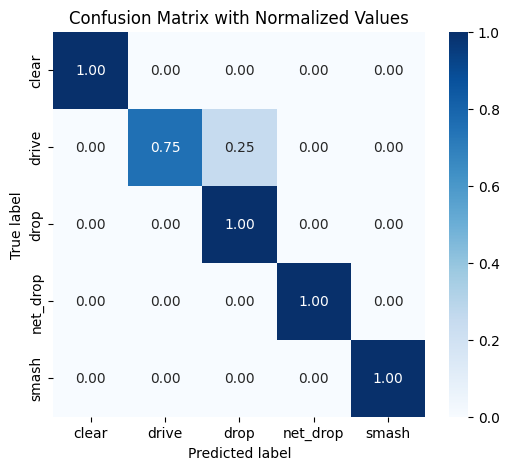

In [46]:
print(classification_report(labels_test, labels_pred, target_names=shot_labels))

# Generate the confusion matrix
cm = confusion_matrix(labels_test, labels_pred)

# Normalise by row sums to get the proportion of true labels per predicted label
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Convert to DataFrame for easier plotting
cm_df = pd.DataFrame(cmn, index=shot_labels, columns=shot_labels)

# Plotting the confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm_df, annot=True, fmt='.2f', cmap='Blues', xticklabels=shot_labels, yticklabels=shot_labels)
plt.title('Confusion Matrix with Normalized Values')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

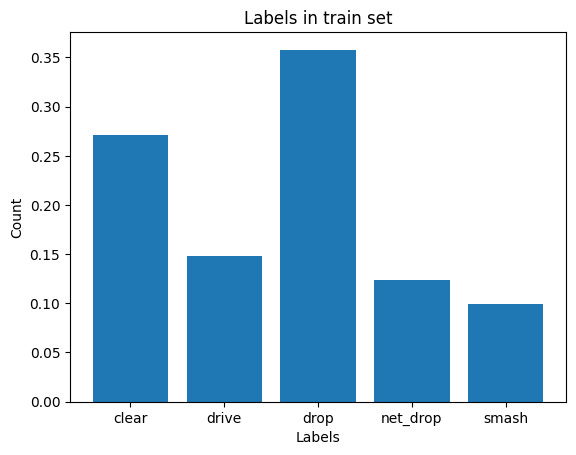

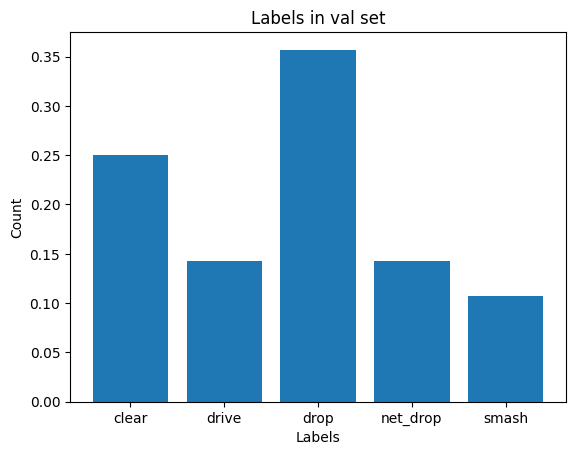

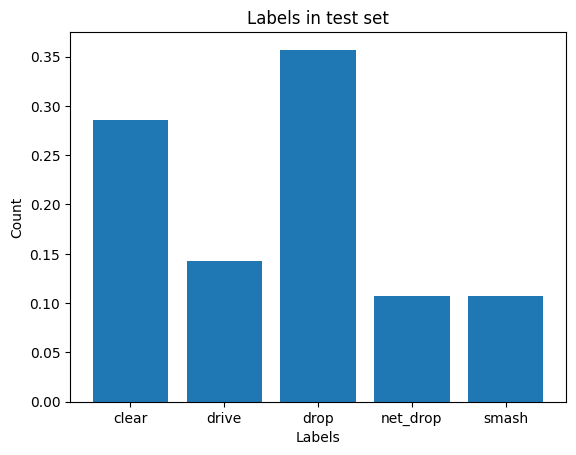

In [42]:
# Put the labels in a list

# Plot labels in train, validation and test sets
plt.bar(shot_labels, labels_train_count)
plt.title('Labels in train set')
plt.ylabel('Count')
plt.xlabel('Labels')
plt.show()

plt.bar(shot_labels, labels_val_count)
plt.title('Labels in val set')
plt.ylabel('Count')
plt.xlabel('Labels')
plt.show()

plt.bar(shot_labels, labels_test_count)
plt.title('Labels in test set')
plt.ylabel('Count')
plt.xlabel('Labels')
plt.show()

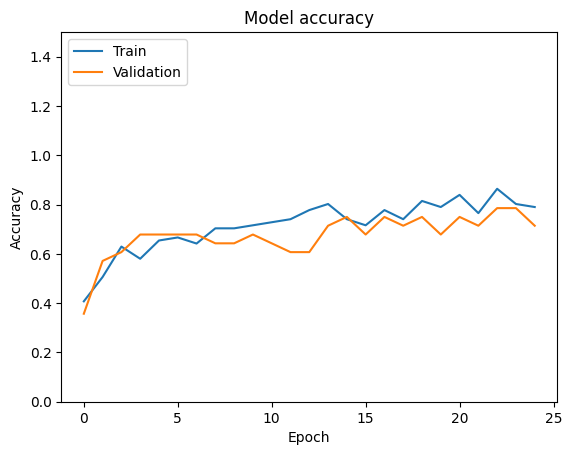

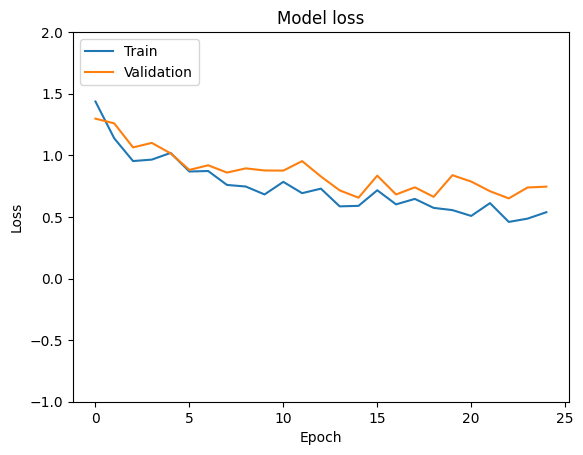

In [43]:
# # Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim(0, 1.5)
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# # Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim(-1, 2)
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [37]:
# Shot detection parameters
window_size = 100  # Size of the sliding window
threshold = 2  # Example threshold for identifying a shot, adjust as needed

# Butterworth filter parameters
order = 3 # Order of the butterworth filter
fs = 50.0 # Sample rate, Hz
cutoff = 4 # Desired cutoff frequency of the filter, Hz

# Best parameters
best_params = {}
best_model = None
models = []

for window_size in [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]:
    for threshold in [1.5, 2, 2.5]:
        for order in [2, 3, 4]:
            for cutoff in [2, 3, 4, 5]:
                params = {
                    'window_size': window_size,
                    'threshold': threshold,
                    'order': order,
                    'cutoff': cutoff
                }
                print(params)

                dataset = construct_dataset(paths, sensors, window_size, threshold, order, fs, cutoff, pl=False, verbose=False)

                # Build the ResNet CNN model
                num_classes = len(shot_labels)  # You mentioned 6 labels for the badminton shots.
                num_features = len(features)  # You mentioned 4 features for the accelerometer data.
                input_shape = (window_size, num_features)

                # Build the model
                model = build_resnet(input_shape, num_classes)

                # Compile the model
                model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

                # Model summary
                # model.summary()

                # Convert the data into numpy arrays
                X = np.array([[shot[feature] for shot in dataset] for feature in ['X', 'Y', 'Z', 'Magnitude']]).reshape(-1, window_size, num_features)
                y = np.array([shot['label'] for shot in dataset])

                print(X.shape)
                print(y.shape)

                # Split the data into train+validation and test sets
                data_train_val, data_test, labels_train_val, labels_test = train_test_split(
                    X, y, test_size=0.2, random_state=42, stratify=y)

                # Split the train+validation set into train and validation sets
                data_train, data_val, labels_train, labels_val = train_test_split(
                    data_train_val, labels_train_val, test_size=0.25, random_state=42, stratify=labels_train_val)

                labels_train_count = np.bincount(labels_train)/len(labels_train)
                labels_val_count = np.bincount(labels_val)/len(labels_val)
                labels_test_count = np.bincount(labels_test)/len(labels_test)

                # # Train the model
                history = model.fit(data_train, labels_train, epochs=25, batch_size=4, validation_data=(data_val, labels_val), verbose=0)

                # Test the model
                loss, acc = model.evaluate(data_test, labels_test)
                print('Test Loss: {}'.format(loss))
                print('Test Accuracy: {}'.format(acc))

                data_test_pred = model(data_test)
                labels_pred = np.argmax(data_test_pred, axis=1)

                print(classification_report(labels_test, labels_pred, target_names=shot_labels))

                # Generate the confusion matrix
                # cm = confusion_matrix(labels_test, labels_pred)

                # # Normalise by row sums to get the proportion of true labels per predicted label
                # cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

                # # Convert to DataFrame for easier plotting
                # cm_df = pd.DataFrame(cmn, index=shot_labels, columns=shot_labels)

                # # Plotting the confusion matrix
                # plt.figure(figsize=(6,5))
                # sns.heatmap(cm_df, annot=True, fmt='.2f', cmap='Blues', xticklabels=shot_labels, yticklabels=shot_labels)
                # plt.title('Confusion Matrix with Normalized Values')
                # plt.ylabel('True label')
                # plt.xlabel('Predicted label')
                # plt.show()

                if best_model == None or acc > best_params['acc']:
                    best_params['window_size'] = window_size
                    best_params['threshold'] = threshold
                    best_params['order'] = order
                    best_params['cutoff'] = cutoff
                    best_params['acc'] = acc
                    best_model = model

                models.append((params, acc))
                models.sort(key=lambda x: x[1], reverse=True)
                print(models)

print(best_params)
print(best_model)
print(models)

{'window_size': 50, 'threshold': 1.5, 'order': 2, 'cutoff': 2}
(203, 50, 4)
(203,)
2/2 [==============================] - 0s 3ms/step - loss: 0.5208 - accuracy: 0.7805
Test Loss: 0.5208252668380737
Test Accuracy: 0.7804877758026123
              precision    recall  f1-score   support

       clear       1.00      1.00      1.00        10
       drive       0.75      0.86      0.80         7
        drop       0.81      0.87      0.84        15
    net_drop       0.33      0.20      0.25         5
       smash       0.50      0.50      0.50         4

    accuracy                           0.78        41
   macro avg       0.68      0.68      0.68        41
weighted avg       0.76      0.78      0.77        41

[({'window_size': 50, 'threshold': 1.5, 'order': 2, 'cutoff': 2}, 0.7804877758026123)]
{'window_size': 50, 'threshold': 1.5, 'order': 2, 'cutoff': 3}
(224, 50, 4)
(224,)
2/2 [==============================] - 0s 3ms/step - loss: 0.7442 - accuracy: 0.6667
Test Loss: 0.74420303106

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(231, 50, 4)
(231,)
2/2 [==============================] - 0s 3ms/step - loss: 0.5757 - accuracy: 0.7447
Test Loss: 0.5757232904434204
Test Accuracy: 0.7446808218955994
              precision    recall  f1-score   support

       clear       1.00      0.91      0.95        11
       drive       0.54      0.88      0.67         8
        drop       0.92      0.67      0.77        18
    net_drop       0.56      0.83      0.67         6
       smash       0.50      0.25      0.33         4

    accuracy                           0.74        47
   macro avg       0.70      0.71      0.68        47
weighted avg       0.79      0.74      0.75        47

[({'window_size': 50, 'threshold': 1.5, 'order': 2, 'cutoff': 2}, 0.7804877758026123), ({'window_size': 50, 'threshold': 1.5, 'order': 2, 'cutoff': 4}, 0.7446808218955994), ({'window_size': 50, 'threshold': 1.5, 'order': 2, 'cutoff': 3}, 0.6666666865348816)]
{'window_size': 50, 'threshold': 1.5, 'order': 2, 'cutoff': 5}
(230, 50, 4)
(230,)


/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(196, 50, 4)
(196,)
2/2 [==============================] - 0s 3ms/step - loss: 0.4673 - accuracy: 0.8250
Test Loss: 0.4672607481479645
Test Accuracy: 0.824999988079071
              precision    recall  f1-score   support

       clear       1.00      1.00      1.00         9
       drive       1.00      0.71      0.83         7
        drop       0.88      0.93      0.90        15
    net_drop       0.67      0.33      0.44         6
       smash       0.43      1.00      0.60         3

    accuracy                           0.82        40
   macro avg       0.79      0.80      0.76        40
weighted avg       0.86      0.82      0.82        40

[({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 2}, 0.824999988079071), ({'window_size': 50, 'threshold': 1.5, 'order': 2, 'cutoff': 2}, 0.7804877758026123), ({'window_size': 50, 'threshold': 1.5, 'order': 2, 'cutoff': 5}, 0.760869562625885), ({'window_size': 50, 'threshold': 1.5, 'order': 2, 'cutoff': 4}, 0.7446808218955994), 

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(178, 50, 4)
(178,)
2/2 [==============================] - 0s 3ms/step - loss: 0.5437 - accuracy: 0.8056
Test Loss: 0.5436615347862244
Test Accuracy: 0.8055555820465088
              precision    recall  f1-score   support

       clear       0.90      1.00      0.95         9
       drive       1.00      1.00      1.00         6
        drop       0.79      0.85      0.81        13
    net_drop       0.00      0.00      0.00         5
       smash       0.60      1.00      0.75         3

    accuracy                           0.81        36
   macro avg       0.66      0.77      0.70        36
weighted avg       0.73      0.81      0.76        36

[({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.8723404407501221), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 2}, 0.824999988079071), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 3}, 0.8181818127632141), ({'window_size': 50, 'threshold': 2, 'order': 2, 'cutoff': 4}, 0.8055555820465088), 

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(182, 50, 4)
(182,)
2/2 [==============================] - 0s 3ms/step - loss: 0.4269 - accuracy: 0.8108
Test Loss: 0.42688262462615967
Test Accuracy: 0.8108108043670654
              precision    recall  f1-score   support

       clear       1.00      1.00      1.00         9
       drive       0.80      0.67      0.73         6
        drop       0.86      0.86      0.86        14
    net_drop       0.56      1.00      0.71         5
       smash       0.00      0.00      0.00         3

    accuracy                           0.81        37
   macro avg       0.64      0.70      0.66        37
weighted avg       0.77      0.81      0.78        37

[({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.8723404407501221), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 2}, 0.824999988079071), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 3}, 0.8181818127632141), ({'window_size': 50, 'threshold': 2, 'order': 4, 'cutoff': 5}, 0.8108108043670654),

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(110, 50, 4)
(110,)
1/1 [==============================] - 0s 15ms/step - loss: 0.5130 - accuracy: 0.6818
Test Loss: 0.5129989981651306
Test Accuracy: 0.6818181872367859
              precision    recall  f1-score   support

       clear       0.88      1.00      0.93         7
       drive       0.50      1.00      0.67         2
        drop       1.00      0.44      0.62         9
    net_drop       0.00      0.00      0.00         2
       smash       0.50      1.00      0.67         2

    accuracy                           0.68        22
   macro avg       0.57      0.69      0.58        22
weighted avg       0.78      0.68      0.67        22

[({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.8723404407501221), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 2}, 0.824999988079071), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 3}, 0.8181818127632141), ({'window_size': 50, 'threshold': 2, 'order': 4, 'cutoff': 5}, 0.8108108043670654),

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(109, 50, 4)
(109,)
1/1 [==============================] - 0s 14ms/step - loss: 1.0377 - accuracy: 0.6364
Test Loss: 1.037746548652649
Test Accuracy: 0.6363636255264282
              precision    recall  f1-score   support

       clear       1.00      0.57      0.73         7
       drive       0.50      0.50      0.50         2
        drop       0.57      0.89      0.70         9
    net_drop       0.00      0.00      0.00         2
       smash       1.00      0.50      0.67         2

    accuracy                           0.64        22
   macro avg       0.61      0.49      0.52        22
weighted avg       0.69      0.64      0.62        22

[({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.8723404407501221), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 2}, 0.824999988079071), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 3}, 0.8181818127632141)

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(133, 50, 4)
(133,)
1/1 [==============================] - 0s 15ms/step - loss: 0.5013 - accuracy: 0.7037
Test Loss: 0.5012999773025513
Test Accuracy: 0.7037037014961243
              precision    recall  f1-score   support

       clear       1.00      0.57      0.73         7
       drive       0.43      1.00      0.60         3
        drop       0.82      0.82      0.82        11
    net_drop       0.00      0.00      0.00         3
       smash       0.75      1.00      0.86         3

    accuracy                           0.70        27
   macro avg       0.60      0.68      0.60        27
weighted avg       0.72      0.70      0.68        27

[({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.8723404407501221), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 2}, 0.824999988079071), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 3}, 0.8181818127632141

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(106, 50, 4)
(106,)
1/1 [==============================] - 0s 15ms/step - loss: 0.8955 - accuracy: 0.7727
Test Loss: 0.8954517245292664
Test Accuracy: 0.7727272510528564
              precision    recall  f1-score   support

       clear       0.86      0.86      0.86         7
       drive       0.00      0.00      0.00         2
        drop       0.67      0.89      0.76         9
    net_drop       1.00      0.50      0.67         2
       smash       1.00      1.00      1.00         2

    accuracy                           0.77        22
   macro avg       0.70      0.65      0.66        22
weighted avg       0.73      0.77      0.74        22

[({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.8723404407501221), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 2}, 0.824999988079071), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 3}, 0.8181818127632141

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(130, 50, 4)
(130,)
1/1 [==============================] - 0s 15ms/step - loss: 0.6092 - accuracy: 0.6923
Test Loss: 0.6092186570167542
Test Accuracy: 0.692307710647583
              precision    recall  f1-score   support

       clear       0.88      1.00      0.93         7
       drive       0.00      0.00      0.00         2
        drop       0.86      0.55      0.67        11
    net_drop       0.67      0.67      0.67         3
       smash       0.75      1.00      0.86         3

    accuracy                           0.69        26
   macro avg       0.63      0.64      0.62        26
weighted avg       0.76      0.69      0.71        26

[({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.8723404407501221), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 2}, 0.824999988079071), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 3}, 0.8181818127632141)

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(209, 60, 4)
(209,)
2/2 [==============================] - 0s 3ms/step - loss: 0.5461 - accuracy: 0.7143
Test Loss: 0.5460999608039856
Test Accuracy: 0.7142857313156128
              precision    recall  f1-score   support

       clear       1.00      0.91      0.95        11
       drive       0.38      0.50      0.43         6
        drop       0.82      0.88      0.85        16
    net_drop       0.43      0.50      0.46         6
       smash       0.00      0.00      0.00         3

    accuracy                           0.71        42
   macro avg       0.53      0.56      0.54        42
weighted avg       0.69      0.71      0.70        42

[({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.8723404407501221), ({'window_size': 60, 'threshold': 1.5, 'order': 2, 'cutoff': 4}, 0.8333333134651184), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 2}, 0.824999988079071)

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(214, 60, 4)
(214,)
2/2 [==============================] - 0s 3ms/step - loss: 0.9037 - accuracy: 0.6744
Test Loss: 0.9036824703216553
Test Accuracy: 0.6744186282157898
              precision    recall  f1-score   support

       clear       1.00      0.91      0.95        11
       drive       0.46      1.00      0.63         6
        drop       1.00      0.47      0.64        17
    net_drop       0.50      0.83      0.62         6
       smash       0.00      0.00      0.00         3

    accuracy                           0.67        43
   macro avg       0.59      0.64      0.57        43
weighted avg       0.79      0.67      0.67        43

[({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.8723404407501221), ({'window_size': 60, 'threshold': 1.5, 'order': 2, 'cutoff': 4}, 0.8333333134651184), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 2}, 0.824999988079071)

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(210, 60, 4)
(210,)
2/2 [==============================] - 0s 3ms/step - loss: 0.6045 - accuracy: 0.8095
Test Loss: 0.60453861951828
Test Accuracy: 0.8095238208770752
              precision    recall  f1-score   support

       clear       1.00      0.91      0.95        11
       drive       0.71      0.83      0.77         6
        drop       0.94      0.94      0.94        16
    net_drop       0.57      0.67      0.62         6
       smash       0.00      0.00      0.00         3

    accuracy                           0.81        42
   macro avg       0.64      0.67      0.65        42
weighted avg       0.80      0.81      0.80        42

[({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.8723404407501221), ({'window_size': 60, 'threshold': 1.5, 'order': 2, 'cutoff': 4}, 0.8333333134651184), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 2}, 0.824999988079071), 

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(139, 60, 4)
(139,)
1/1 [==============================] - 0s 159ms/step - loss: 0.7113 - accuracy: 0.6786
Test Loss: 0.7113211750984192
Test Accuracy: 0.6785714030265808
              precision    recall  f1-score   support

       clear       1.00      0.57      0.73         7
       drive       0.40      1.00      0.57         4
        drop       0.80      0.73      0.76        11
    net_drop       0.50      0.33      0.40         3
       smash       1.00      0.67      0.80         3

    accuracy                           0.68        28
   macro avg       0.74      0.66      0.65        28
weighted avg       0.78      0.68      0.69        28

[({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.8723404407501221), ({'window_size': 60, 'threshold': 1.5, 'order': 2, 'cutoff': 4}, 0.8333333134651184), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 2}, 0.82499998807907

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(174, 60, 4)
(174,)
2/2 [==============================] - 0s 3ms/step - loss: 0.5504 - accuracy: 0.7429
Test Loss: 0.5504128336906433
Test Accuracy: 0.7428571581840515
              precision    recall  f1-score   support

       clear       1.00      0.78      0.88         9
       drive       0.60      1.00      0.75         6
        drop       0.88      0.54      0.67        13
    net_drop       0.75      0.75      0.75         4
       smash       0.50      1.00      0.67         3

    accuracy                           0.74        35
   macro avg       0.74      0.81      0.74        35
weighted avg       0.81      0.74      0.74        35

[({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.8723404407501221), ({'window_size': 60, 'threshold': 1.5, 'order': 2, 'cutoff': 4}, 0.8333333134651184), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 2}, 0.824999988079071)

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(169, 60, 4)
(169,)
2/2 [==============================] - 0s 2ms/step - loss: 0.5263 - accuracy: 0.7941
Test Loss: 0.5262908339500427
Test Accuracy: 0.7941176295280457
              precision    recall  f1-score   support

       clear       1.00      1.00      1.00         9
       drive       0.60      0.60      0.60         5
        drop       0.82      0.69      0.75        13
    net_drop       0.57      1.00      0.73         4
       smash       1.00      0.67      0.80         3

    accuracy                           0.79        34
   macro avg       0.80      0.79      0.78        34
weighted avg       0.82      0.79      0.80        34

[({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.8723404407501221), ({'window_size': 60, 'threshold': 1.5, 'order': 2, 'cutoff': 4}, 0.8333333134651184), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 2}, 0.824999988079071)

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(174, 60, 4)
(174,)
2/2 [==============================] - 0s 3ms/step - loss: 0.6007 - accuracy: 0.8000
Test Loss: 0.6006929874420166
Test Accuracy: 0.800000011920929
              precision    recall  f1-score   support

       clear       1.00      0.78      0.88         9
       drive       0.86      1.00      0.92         6
        drop       0.75      0.92      0.83        13
    net_drop       0.50      0.25      0.33         4
       smash       0.67      0.67      0.67         3

    accuracy                           0.80        35
   macro avg       0.75      0.72      0.73        35
weighted avg       0.80      0.80      0.79        35

[({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.8723404407501221), ({'window_size': 60, 'threshold': 1.5, 'order': 2, 'cutoff': 4}, 0.8333333134651184), ({'window_size': 60, 'threshold': 2, 'order': 3, 'cutoff': 5}, 0.8285714387893677), 

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(131, 60, 4)
(131,)
1/1 [==============================] - 0s 16ms/step - loss: 1.0254 - accuracy: 0.7037
Test Loss: 1.0253721475601196
Test Accuracy: 0.7037037014961243
              precision    recall  f1-score   support

       clear       1.00      1.00      1.00         7
       drive       0.40      0.67      0.50         3
        drop       0.73      0.73      0.73        11
    net_drop       0.33      0.33      0.33         3
       smash       1.00      0.33      0.50         3

    accuracy                           0.70        27
   macro avg       0.69      0.61      0.61        27
weighted avg       0.75      0.70      0.70        27

[({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.8723404407501221), ({'window_size': 60, 'threshold': 1.5, 'order': 2, 'cutoff': 4}, 0.8333333134651184), ({'window_size': 60, 'threshold': 2, 'order': 3, 'cutoff': 5}, 0.8285714387893677)

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(125, 60, 4)
(125,)
1/1 [==============================] - 0s 18ms/step - loss: 0.5813 - accuracy: 0.7600
Test Loss: 0.5812849402427673
Test Accuracy: 0.7599999904632568
              precision    recall  f1-score   support

       clear       1.00      1.00      1.00         7
       drive       0.29      1.00      0.44         2
        drop       1.00      0.50      0.67        10
    net_drop       1.00      0.67      0.80         3
       smash       0.75      1.00      0.86         3

    accuracy                           0.76        25
   macro avg       0.81      0.83      0.75        25
weighted avg       0.91      0.76      0.78        25

[({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.8723404407501221), ({'window_size': 60, 'threshold': 1.5, 'order': 2, 'cutoff': 4}, 0.8333333134651184), ({'window_size': 60, 'threshold': 2, 'order': 3, 'cutoff': 5}, 0.8285714387893677)

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(127, 60, 4)
(127,)
1/1 [==============================] - 0s 14ms/step - loss: 0.4507 - accuracy: 0.7692
Test Loss: 0.45070379972457886
Test Accuracy: 0.7692307829856873
              precision    recall  f1-score   support

       clear       1.00      1.00      1.00         7
       drive       0.33      0.33      0.33         3
        drop       0.73      0.80      0.76        10
    net_drop       1.00      0.33      0.50         3
       smash       0.75      1.00      0.86         3

    accuracy                           0.77        26
   macro avg       0.76      0.69      0.69        26
weighted avg       0.79      0.77      0.76        26

[({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.8723404407501221), ({'window_size': 60, 'threshold': 1.5, 'order': 2, 'cutoff': 4}, 0.8333333134651184), ({'window_size': 60, 'threshold': 2, 'order': 3, 'cutoff': 5}, 0.8285714387893677

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(137, 60, 4)
(137,)
1/1 [==============================] - 0s 156ms/step - loss: 0.6689 - accuracy: 0.7143
Test Loss: 0.6689013838768005
Test Accuracy: 0.7142857313156128
              precision    recall  f1-score   support

       clear       1.00      0.86      0.92         7
       drive       1.00      0.50      0.67         4
        drop       0.65      1.00      0.79        11
    net_drop       0.33      0.33      0.33         3
       smash       0.00      0.00      0.00         3

    accuracy                           0.71        28
   macro avg       0.60      0.54      0.54        28
weighted avg       0.68      0.71      0.67        28

[({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.8723404407501221), ({'window_size': 60, 'threshold': 1.5, 'order': 2, 'cutoff': 4}, 0.8333333134651184), ({'window_size': 60, 'threshold': 2, 'order': 3, 'cutoff': 5}, 0.8285714387893677

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(170, 70, 4)
(170,)
2/2 [==============================] - 0s 2ms/step - loss: 0.5290 - accuracy: 0.7647
Test Loss: 0.528960108757019
Test Accuracy: 0.7647058963775635
              precision    recall  f1-score   support

       clear       1.00      1.00      1.00         8
       drive       0.67      0.40      0.50         5
        drop       0.79      0.85      0.81        13
    net_drop       0.56      1.00      0.71         5
       smash       0.00      0.00      0.00         3

    accuracy                           0.76        34
   macro avg       0.60      0.65      0.61        34
weighted avg       0.72      0.76      0.73        34

[({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.8723404407501221), ({'window_size': 60, 'threshold': 1.5, 'order': 2, 'cutoff': 4}, 0.8333333134651184), ({'window_size': 60, 'threshold': 2, 'order': 3, 'cutoff': 5}, 0.8285714387893677), 

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(184, 70, 4)
(184,)
2/2 [==============================] - 0s 3ms/step - loss: 0.6893 - accuracy: 0.7838
Test Loss: 0.6893101930618286
Test Accuracy: 0.7837837934494019
              precision    recall  f1-score   support

       clear       1.00      0.67      0.80         9
       drive       0.67      0.67      0.67         6
        drop       0.73      0.79      0.76        14
    net_drop       0.71      1.00      0.83         5
       smash       1.00      1.00      1.00         3

    accuracy                           0.78        37
   macro avg       0.82      0.82      0.81        37
weighted avg       0.81      0.78      0.78        37

[({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.8723404407501221), ({'window_size': 60, 'threshold': 1.5, 'order': 2, 'cutoff': 4}, 0.8333333134651184), ({'window_size': 60, 'threshold': 2, 'order': 3, 'cutoff': 5}, 0.8285714387893677),

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(185, 70, 4)
(185,)
2/2 [==============================] - 0s 3ms/step - loss: 0.6506 - accuracy: 0.6486
Test Loss: 0.6506214737892151
Test Accuracy: 0.6486486196517944
              precision    recall  f1-score   support

       clear       1.00      1.00      1.00         9
       drive       0.31      0.80      0.44         5
        drop       0.90      0.60      0.72        15
    net_drop       0.50      0.40      0.44         5
       smash       0.00      0.00      0.00         3

    accuracy                           0.65        37
   macro avg       0.54      0.56      0.52        37
weighted avg       0.72      0.65      0.66        37

[({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.8723404407501221), ({'window_size': 60, 'threshold': 1.5, 'order': 2, 'cutoff': 4}, 0.8333333134651184), ({'window_size': 60, 'threshold': 2, 'order': 3, 'cutoff': 5}, 0.8285714387893677),

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(164, 70, 4)
(164,)
2/2 [==============================] - 0s 4ms/step - loss: 0.5084 - accuracy: 0.8182
Test Loss: 0.5083609819412231
Test Accuracy: 0.8181818127632141
              precision    recall  f1-score   support

       clear       1.00      0.88      0.93         8
       drive       0.50      0.40      0.44         5
        drop       0.79      0.92      0.85        12
    net_drop       1.00      0.80      0.89         5
       smash       0.75      1.00      0.86         3

    accuracy                           0.82        33
   macro avg       0.81      0.80      0.79        33
weighted avg       0.82      0.82      0.81        33

[({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.8723404407501221), ({'window_size': 70, 'threshold': 1.5, 'order': 3, 'cutoff': 4}, 0.837837815284729), ({'window_size': 60, 'threshold': 1.5, 'order': 2, 'cutoff': 4}, 0.8333333134651184)

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(188, 70, 4)
(188,)
2/2 [==============================] - 0s 3ms/step - loss: 0.6840 - accuracy: 0.6842
Test Loss: 0.6839972138404846
Test Accuracy: 0.6842105388641357
              precision    recall  f1-score   support

       clear       1.00      0.56      0.71         9
       drive       0.60      0.50      0.55         6
        drop       0.70      0.93      0.80        15
    net_drop       1.00      0.20      0.33         5
       smash       0.43      1.00      0.60         3

    accuracy                           0.68        38
   macro avg       0.75      0.64      0.60        38
weighted avg       0.77      0.68      0.66        38

[({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.8723404407501221), ({'window_size': 70, 'threshold': 1.5, 'order': 3, 'cutoff': 4}, 0.837837815284729), ({'window_size': 60, 'threshold': 1.5, 'order': 2, 'cutoff': 4}, 0.8333333134651184)

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(164, 70, 4)
(164,)
2/2 [==============================] - 0s 2ms/step - loss: 0.8004 - accuracy: 0.6061
Test Loss: 0.8004387617111206
Test Accuracy: 0.6060606241226196
              precision    recall  f1-score   support

       clear       1.00      0.50      0.67         8
       drive       0.43      0.60      0.50         5
        drop       0.59      0.77      0.67        13
    net_drop       0.00      0.00      0.00         4
       smash       0.60      1.00      0.75         3

    accuracy                           0.61        33
   macro avg       0.52      0.57      0.52        33
weighted avg       0.59      0.61      0.57        33

[({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.8723404407501221), ({'window_size': 70, 'threshold': 1.5, 'order': 3, 'cutoff': 4}, 0.837837815284729), ({'window_size': 60, 'threshold': 1.5, 'order': 2, 'cutoff': 4}, 0.8333333134651184)

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(134, 70, 4)
(134,)
1/1 [==============================] - 0s 16ms/step - loss: 0.5526 - accuracy: 0.5926
Test Loss: 0.5526395440101624
Test Accuracy: 0.5925925970077515
              precision    recall  f1-score   support

       clear       1.00      0.86      0.92         7
       drive       0.50      0.25      0.33         4
        drop       0.56      0.90      0.69        10
    net_drop       0.00      0.00      0.00         3
       smash       0.00      0.00      0.00         3

    accuracy                           0.59        27
   macro avg       0.41      0.40      0.39        27
weighted avg       0.54      0.59      0.55        27

[({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.8723404407501221), ({'window_size': 70, 'threshold': 1.5, 'order': 3, 'cutoff': 4}, 0.837837815284729), ({'window_size': 60, 'threshold': 1.5, 'order': 2, 'cutoff': 4}, 0.8333333134651184

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(150, 70, 4)
(150,)
1/1 [==============================] - 0s 16ms/step - loss: 0.4898 - accuracy: 0.7000
Test Loss: 0.4897652268409729
Test Accuracy: 0.699999988079071
              precision    recall  f1-score   support

       clear       1.00      1.00      1.00         8
       drive       0.44      1.00      0.62         4
        drop       1.00      0.64      0.78        11
    net_drop       0.40      0.50      0.44         4
       smash       0.00      0.00      0.00         3

    accuracy                           0.70        30
   macro avg       0.57      0.63      0.57        30
weighted avg       0.75      0.70      0.69        30

[({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.8723404407501221), ({'window_size': 70, 'threshold': 1.5, 'order': 3, 'cutoff': 4}, 0.837837815284729), ({'window_size': 60, 'threshold': 1.5, 'order': 2, 'cutoff': 4}, 0.8333333134651184)

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(131, 70, 4)
(131,)
1/1 [==============================] - 0s 15ms/step - loss: 0.5425 - accuracy: 0.6667
Test Loss: 0.5425464510917664
Test Accuracy: 0.6666666865348816
              precision    recall  f1-score   support

       clear       1.00      1.00      1.00         8
       drive       0.33      0.33      0.33         3
        drop       0.67      0.80      0.73        10
    net_drop       0.25      0.33      0.29         3
       smash       0.00      0.00      0.00         3

    accuracy                           0.67        27
   macro avg       0.45      0.49      0.47        27
weighted avg       0.61      0.67      0.63        27

[({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.8723404407501221), ({'window_size': 70, 'threshold': 1.5, 'order': 3, 'cutoff': 4}, 0.837837815284729), ({'window_size': 60, 'threshold': 1.5, 'order': 2, 'cutoff': 4}, 0.8333333134651184

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(152, 70, 4)
(152,)
1/1 [==============================] - 0s 16ms/step - loss: 0.5577 - accuracy: 0.7419
Test Loss: 0.5577006936073303
Test Accuracy: 0.7419354915618896
              precision    recall  f1-score   support

       clear       1.00      0.88      0.93         8
       drive       0.50      0.50      0.50         4
        drop       0.85      0.92      0.88        12
    net_drop       0.00      0.00      0.00         4
       smash       0.43      1.00      0.60         3

    accuracy                           0.74        31
   macro avg       0.55      0.66      0.58        31
weighted avg       0.69      0.74      0.70        31

[({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.8723404407501221), ({'window_size': 70, 'threshold': 1.5, 'order': 3, 'cutoff': 4}, 0.837837815284729), ({'window_size': 60, 'threshold': 1.5, 'order': 2, 'cutoff': 4}, 0.8333333134651184

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(161, 70, 4)
(161,)
2/2 [==============================] - 0s 3ms/step - loss: 0.4075 - accuracy: 0.8182
Test Loss: 0.40752553939819336
Test Accuracy: 0.8181818127632141
              precision    recall  f1-score   support

       clear       1.00      1.00      1.00         8
       drive       1.00      0.60      0.75         5
        drop       0.81      1.00      0.90        13
    net_drop       0.50      0.75      0.60         4
       smash       0.00      0.00      0.00         3

    accuracy                           0.82        33
   macro avg       0.66      0.67      0.65        33
weighted avg       0.77      0.82      0.78        33

[({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.8723404407501221), ({'window_size': 70, 'threshold': 1.5, 'order': 3, 'cutoff': 4}, 0.837837815284729), ({'window_size': 60, 'threshold': 1.5, 'order': 2, 'cutoff': 4}, 0.8333333134651184

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(164, 70, 4)
(164,)
2/2 [==============================] - 0s 2ms/step - loss: 0.5552 - accuracy: 0.7273
Test Loss: 0.5552253127098083
Test Accuracy: 0.7272727489471436
              precision    recall  f1-score   support

       clear       1.00      1.00      1.00         8
       drive       0.60      0.60      0.60         5
        drop       0.69      0.85      0.76        13
    net_drop       0.00      0.00      0.00         4
       smash       0.50      0.67      0.57         3

    accuracy                           0.73        33
   macro avg       0.56      0.62      0.59        33
weighted avg       0.65      0.73      0.68        33

[({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.8723404407501221), ({'window_size': 70, 'threshold': 1.5, 'order': 3, 'cutoff': 4}, 0.837837815284729), ({'window_size': 60, 'threshold': 1.5, 'order': 2, 'cutoff': 4}, 0.8333333134651184)

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(109, 70, 4)
(109,)
1/1 [==============================] - 0s 18ms/step - loss: 0.5455 - accuracy: 0.7727
Test Loss: 0.5455198884010315
Test Accuracy: 0.7727272510528564
              precision    recall  f1-score   support

       clear       0.88      1.00      0.93         7
       drive       0.33      0.50      0.40         2
        drop       0.86      0.67      0.75         9
    net_drop       0.67      1.00      0.80         2
       smash       1.00      0.50      0.67         2

    accuracy                           0.77        22
   macro avg       0.75      0.73      0.71        22
weighted avg       0.81      0.77      0.77        22

[({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.8723404407501221), ({'window_size': 70, 'threshold': 1.5, 'order': 3, 'cutoff': 4}, 0.837837815284729), ({'window_size': 60, 'threshold': 1.5, 'order': 2, 'cutoff': 4}, 0.8333333134651184

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(126, 70, 4)
(126,)
1/1 [==============================] - 0s 16ms/step - loss: 0.5427 - accuracy: 0.7692
Test Loss: 0.5427076816558838
Test Accuracy: 0.7692307829856873
              precision    recall  f1-score   support

       clear       1.00      1.00      1.00         7
       drive       0.50      1.00      0.67         3
        drop       0.88      0.70      0.78        10
    net_drop       0.00      0.00      0.00         3
       smash       0.60      1.00      0.75         3

    accuracy                           0.77        26
   macro avg       0.59      0.74      0.64        26
weighted avg       0.73      0.77      0.73        26

[({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.8723404407501221), ({'window_size': 70, 'threshold': 1.5, 'order': 3, 'cutoff': 4}, 0.837837815284729), ({'window_size': 60, 'threshold': 1.5, 'order': 2, 'cutoff': 4}, 0.8333333134651184

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(129, 70, 4)
(129,)
1/1 [==============================] - 0s 17ms/step - loss: 0.6075 - accuracy: 0.7308
Test Loss: 0.6075375080108643
Test Accuracy: 0.7307692170143127
              precision    recall  f1-score   support

       clear       1.00      1.00      1.00         7
       drive       0.38      1.00      0.55         3
        drop       1.00      0.50      0.67        10
    net_drop       0.60      1.00      0.75         3
       smash       1.00      0.33      0.50         3

    accuracy                           0.73        26
   macro avg       0.80      0.77      0.69        26
weighted avg       0.88      0.73      0.73        26

[({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.8723404407501221), ({'window_size': 70, 'threshold': 1.5, 'order': 3, 'cutoff': 4}, 0.837837815284729), ({'window_size': 60, 'threshold': 1.5, 'order': 2, 'cutoff': 4}, 0.8333333134651184

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(130, 70, 4)
(130,)
1/1 [==============================] - 0s 16ms/step - loss: 1.6519 - accuracy: 0.5769
Test Loss: 1.6519486904144287
Test Accuracy: 0.5769230723381042
              precision    recall  f1-score   support

       clear       1.00      1.00      1.00         7
       drive       0.17      0.33      0.22         3
        drop       0.56      0.50      0.53        10
    net_drop       0.00      0.00      0.00         3
       smash       0.67      0.67      0.67         3

    accuracy                           0.58        26
   macro avg       0.48      0.50      0.48        26
weighted avg       0.58      0.58      0.57        26

[({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.8723404407501221), ({'window_size': 70, 'threshold': 1.5, 'order': 3, 'cutoff': 4}, 0.837837815284729), ({'window_size': 60, 'threshold': 1.5, 'order': 2, 'cutoff': 4}, 0.8333333134651184

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(130, 70, 4)
(130,)
1/1 [==============================] - 0s 16ms/step - loss: 0.9265 - accuracy: 0.6538
Test Loss: 0.9264612793922424
Test Accuracy: 0.6538461446762085
              precision    recall  f1-score   support

       clear       1.00      1.00      1.00         7
       drive       0.33      0.33      0.33         3
        drop       0.67      0.80      0.73        10
    net_drop       0.25      0.33      0.29         3
       smash       0.00      0.00      0.00         3

    accuracy                           0.65        26
   macro avg       0.45      0.49      0.47        26
weighted avg       0.59      0.65      0.62        26

[({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.8723404407501221), ({'window_size': 70, 'threshold': 2.5, 'order': 4, 'cutoff': 3}, 0.8399999737739563), ({'window_size': 70, 'threshold': 1.5, 'order': 3, 'cutoff': 4}, 0.837837815284729

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(135, 70, 4)
(135,)
1/1 [==============================] - 0s 15ms/step - loss: 0.4428 - accuracy: 0.7407
Test Loss: 0.4427856504917145
Test Accuracy: 0.7407407164573669
              precision    recall  f1-score   support

       clear       1.00      1.00      1.00         7
       drive       0.50      0.75      0.60         4
        drop       0.88      0.70      0.78        10
    net_drop       0.40      0.67      0.50         3
       smash       1.00      0.33      0.50         3

    accuracy                           0.74        27
   macro avg       0.76      0.69      0.68        27
weighted avg       0.81      0.74      0.75        27

[({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.8723404407501221), ({'window_size': 70, 'threshold': 2.5, 'order': 4, 'cutoff': 3}, 0.8399999737739563), ({'window_size': 70, 'threshold': 1.5, 'order': 3, 'cutoff': 4}, 0.837837815284729

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(165, 80, 4)
(165,)
2/2 [==============================] - 0s 2ms/step - loss: 0.5954 - accuracy: 0.7273
Test Loss: 0.5954319834709167
Test Accuracy: 0.7272727489471436
              precision    recall  f1-score   support

       clear       1.00      0.75      0.86         8
       drive       1.00      0.40      0.57         5
        drop       0.68      1.00      0.81        13
    net_drop       0.50      0.75      0.60         4
       smash       0.00      0.00      0.00         3

    accuracy                           0.73        33
   macro avg       0.64      0.58      0.57        33
weighted avg       0.72      0.73      0.69        33

[({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.8723404407501221), ({'window_size': 70, 'threshold': 2.5, 'order': 4, 'cutoff': 3}, 0.8399999737739563), ({'window_size': 70, 'threshold': 1.5, 'order': 3, 'cutoff': 4}, 0.837837815284729)

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(166, 80, 4)
(166,)
2/2 [==============================] - 0s 3ms/step - loss: 0.6144 - accuracy: 0.7647
Test Loss: 0.6144448518753052
Test Accuracy: 0.7647058963775635
              precision    recall  f1-score   support

       clear       1.00      0.89      0.94         9
       drive       0.75      0.60      0.67         5
        drop       0.75      0.92      0.83        13
    net_drop       0.50      0.75      0.60         4
       smash       0.00      0.00      0.00         3

    accuracy                           0.76        34
   macro avg       0.60      0.63      0.61        34
weighted avg       0.72      0.76      0.73        34

[({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.8723404407501221), ({'window_size': 70, 'threshold': 2.5, 'order': 4, 'cutoff': 3}, 0.8399999737739563), ({'window_size': 70, 'threshold': 1.5, 'order': 3, 'cutoff': 4}, 0.837837815284729)

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(169, 80, 4)
(169,)
2/2 [==============================] - 0s 3ms/step - loss: 0.8223 - accuracy: 0.6176
Test Loss: 0.8222759962081909
Test Accuracy: 0.6176470518112183
              precision    recall  f1-score   support

       clear       1.00      0.67      0.80         9
       drive       0.36      1.00      0.53         5
        drop       0.88      0.54      0.67        13
    net_drop       0.50      0.50      0.50         4
       smash       0.50      0.33      0.40         3

    accuracy                           0.62        34
   macro avg       0.65      0.61      0.58        34
weighted avg       0.75      0.62      0.64        34

[({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.8723404407501221), ({'window_size': 70, 'threshold': 2.5, 'order': 4, 'cutoff': 3}, 0.8399999737739563), ({'window_size': 70, 'threshold': 1.5, 'order': 3, 'cutoff': 4}, 0.837837815284729)

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(167, 80, 4)
(167,)
2/2 [==============================] - 0s 3ms/step - loss: 0.4424 - accuracy: 0.7941
Test Loss: 0.4423907697200775
Test Accuracy: 0.7941176295280457
              precision    recall  f1-score   support

       clear       0.90      1.00      0.95         9
       drive       0.75      0.60      0.67         5
        drop       0.73      0.85      0.79        13
    net_drop       1.00      0.25      0.40         4
       smash       0.75      1.00      0.86         3

    accuracy                           0.79        34
   macro avg       0.83      0.74      0.73        34
weighted avg       0.81      0.79      0.77        34

[({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.8723404407501221), ({'window_size': 70, 'threshold': 2.5, 'order': 4, 'cutoff': 3}, 0.8399999737739563), ({'window_size': 70, 'threshold': 1.5, 'order': 3, 'cutoff': 4}, 0.837837815284729)

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(148, 80, 4)
(148,)
1/1 [==============================] - 0s 15ms/step - loss: 0.5076 - accuracy: 0.7333
Test Loss: 0.5076344013214111
Test Accuracy: 0.7333333492279053
              precision    recall  f1-score   support

       clear       1.00      1.00      1.00         7
       drive       0.56      1.00      0.71         5
        drop       1.00      0.55      0.71        11
    net_drop       0.50      1.00      0.67         4
       smash       0.00      0.00      0.00         3

    accuracy                           0.73        30
   macro avg       0.61      0.71      0.62        30
weighted avg       0.76      0.73      0.70        30

[({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.8723404407501221), ({'window_size': 70, 'threshold': 2.5, 'order': 4, 'cutoff': 3}, 0.8399999737739563), ({'window_size': 70, 'threshold': 1.5, 'order': 3, 'cutoff': 4}, 0.837837815284729

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(164, 80, 4)
(164,)
2/2 [==============================] - 0s 2ms/step - loss: 0.5271 - accuracy: 0.8182
Test Loss: 0.5270876884460449
Test Accuracy: 0.8181818127632141
              precision    recall  f1-score   support

       clear       1.00      1.00      1.00         8
       drive       1.00      0.60      0.75         5
        drop       0.81      1.00      0.90        13
    net_drop       0.00      0.00      0.00         4
       smash       0.50      1.00      0.67         3

    accuracy                           0.82        33
   macro avg       0.66      0.72      0.66        33
weighted avg       0.76      0.82      0.77        33

[({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.8723404407501221), ({'window_size': 70, 'threshold': 2.5, 'order': 4, 'cutoff': 3}, 0.8399999737739563), ({'window_size': 70, 'threshold': 1.5, 'order': 3, 'cutoff': 4}, 0.837837815284729)

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(166, 80, 4)
(166,)
2/2 [==============================] - 0s 3ms/step - loss: 0.4703 - accuracy: 0.7647
Test Loss: 0.4703252911567688
Test Accuracy: 0.7647058963775635
              precision    recall  f1-score   support

       clear       1.00      1.00      1.00         9
       drive       0.50      0.80      0.62         5
        drop       0.82      0.69      0.75        13
    net_drop       0.60      0.75      0.67         4
       smash       1.00      0.33      0.50         3

    accuracy                           0.76        34
   macro avg       0.78      0.72      0.71        34
weighted avg       0.81      0.76      0.76        34

[({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.8723404407501221), ({'window_size': 70, 'threshold': 2.5, 'order': 4, 'cutoff': 3}, 0.8399999737739563), ({'window_size': 70, 'threshold': 1.5, 'order': 3, 'cutoff': 4}, 0.837837815284729)

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(146, 80, 4)
(146,)
1/1 [==============================] - 0s 15ms/step - loss: 0.7578 - accuracy: 0.7333
Test Loss: 0.7577823996543884
Test Accuracy: 0.7333333492279053
              precision    recall  f1-score   support

       clear       1.00      0.88      0.93         8
       drive       0.56      1.00      0.71         5
        drop       0.73      0.73      0.73        11
    net_drop       0.50      0.33      0.40         3
       smash       1.00      0.33      0.50         3

    accuracy                           0.73        30
   macro avg       0.76      0.65      0.65        30
weighted avg       0.78      0.73      0.72        30

[({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.8723404407501221), ({'window_size': 70, 'threshold': 2.5, 'order': 4, 'cutoff': 3}, 0.8399999737739563), ({'window_size': 70, 'threshold': 1.5, 'order': 3, 'cutoff': 4}, 0.837837815284729

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(117, 80, 4)
(117,)
1/1 [==============================] - 0s 168ms/step - loss: 0.4830 - accuracy: 0.7917
Test Loss: 0.48299479484558105
Test Accuracy: 0.7916666865348816
              precision    recall  f1-score   support

       clear       1.00      1.00      1.00         7
       drive       0.00      0.00      0.00         2
        drop       0.80      0.89      0.84         9
    net_drop       0.50      0.33      0.40         3
       smash       0.60      1.00      0.75         3

    accuracy                           0.79        24
   macro avg       0.58      0.64      0.60        24
weighted avg       0.73      0.79      0.75        24

[({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.8723404407501221), ({'window_size': 70, 'threshold': 2.5, 'order': 4, 'cutoff': 3}, 0.8399999737739563), ({'window_size': 70, 'threshold': 1.5, 'order': 3, 'cutoff': 4}, 0.8378378152847

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(123, 80, 4)
(123,)
1/1 [==============================] - 0s 16ms/step - loss: 0.6124 - accuracy: 0.7200
Test Loss: 0.6124279499053955
Test Accuracy: 0.7200000286102295
              precision    recall  f1-score   support

       clear       1.00      0.71      0.83         7
       drive       0.43      1.00      0.60         3
        drop       0.75      0.60      0.67        10
    net_drop       0.67      1.00      0.80         2
       smash       1.00      0.67      0.80         3

    accuracy                           0.72        25
   macro avg       0.77      0.80      0.74        25
weighted avg       0.80      0.72      0.73        25

[({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.8723404407501221), ({'window_size': 70, 'threshold': 2.5, 'order': 4, 'cutoff': 3}, 0.8399999737739563), ({'window_size': 70, 'threshold': 1.5, 'order': 3, 'cutoff': 4}, 0.837837815284729

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(141, 90, 4)
(141,)
1/1 [==============================] - 0s 163ms/step - loss: 0.3832 - accuracy: 0.8276
Test Loss: 0.3831573724746704
Test Accuracy: 0.8275862336158752
              precision    recall  f1-score   support

       clear       1.00      1.00      1.00         8
       drive       0.57      1.00      0.73         4
        drop       1.00      0.70      0.82        10
    net_drop       0.67      1.00      0.80         4
       smash       1.00      0.33      0.50         3

    accuracy                           0.83        29
   macro avg       0.85      0.81      0.77        29
weighted avg       0.89      0.83      0.82        29

[({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.8723404407501221), ({'window_size': 70, 'threshold': 2.5, 'order': 4, 'cutoff': 3}, 0.8399999737739563), ({'window_size': 70, 'threshold': 1.5, 'order': 3, 'cutoff': 4}, 0.83783781528472

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(145, 90, 4)
(145,)
1/1 [==============================] - 0s 16ms/step - loss: 0.7726 - accuracy: 0.6897
Test Loss: 0.7725620865821838
Test Accuracy: 0.6896551847457886
              precision    recall  f1-score   support

       clear       1.00      0.88      0.93         8
       drive       0.50      0.50      0.50         4
        drop       0.69      0.90      0.78        10
    net_drop       0.40      0.50      0.44         4
       smash       0.00      0.00      0.00         3

    accuracy                           0.69        29
   macro avg       0.52      0.55      0.53        29
weighted avg       0.64      0.69      0.66        29

[({'window_size': 90, 'threshold': 1.5, 'order': 2, 'cutoff': 3}, 0.8965517282485962), ({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.8723404407501221), ({'window_size': 70, 'threshold': 2.5, 'order': 4, 'cutoff': 3}, 0.839999973773956

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(153, 90, 4)
(153,)
1/1 [==============================] - 0s 15ms/step - loss: 0.7093 - accuracy: 0.7097
Test Loss: 0.709281861782074
Test Accuracy: 0.7096773982048035
              precision    recall  f1-score   support

       clear       1.00      0.88      0.93         8
       drive       1.00      0.40      0.57         5
        drop       0.65      1.00      0.79        11
    net_drop       0.40      0.50      0.44         4
       smash       0.00      0.00      0.00         3

    accuracy                           0.71        31
   macro avg       0.61      0.55      0.55        31
weighted avg       0.70      0.71      0.67        31

[({'window_size': 90, 'threshold': 1.5, 'order': 2, 'cutoff': 3}, 0.8965517282485962), ({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.8723404407501221), ({'window_size': 70, 'threshold': 2.5, 'order': 4, 'cutoff': 3}, 0.8399999737739563

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(126, 90, 4)
(126,)
1/1 [==============================] - 0s 20ms/step - loss: 0.5932 - accuracy: 0.6538
Test Loss: 0.5932178497314453
Test Accuracy: 0.6538461446762085
              precision    recall  f1-score   support

       clear       1.00      1.00      1.00         8
       drive       0.29      0.67      0.40         3
        drop       0.83      0.56      0.67         9
    net_drop       0.50      0.67      0.57         3
       smash       0.00      0.00      0.00         3

    accuracy                           0.65        26
   macro avg       0.52      0.58      0.53        26
weighted avg       0.69      0.65      0.65        26

[({'window_size': 90, 'threshold': 1.5, 'order': 2, 'cutoff': 3}, 0.8965517282485962), ({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.8723404407501221), ({'window_size': 70, 'threshold': 2.5, 'order': 4, 'cutoff': 3}, 0.839999973773956

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(135, 90, 4)
(135,)
1/1 [==============================] - 0s 15ms/step - loss: 0.6081 - accuracy: 0.8148
Test Loss: 0.6080936789512634
Test Accuracy: 0.8148148059844971
              precision    recall  f1-score   support

       clear       1.00      1.00      1.00         7
       drive       0.67      1.00      0.80         4
        drop       0.80      0.80      0.80        10
    net_drop       0.00      0.00      0.00         3
       smash       0.75      1.00      0.86         3

    accuracy                           0.81        27
   macro avg       0.64      0.76      0.69        27
weighted avg       0.74      0.81      0.77        27

[({'window_size': 90, 'threshold': 1.5, 'order': 2, 'cutoff': 3}, 0.8965517282485962), ({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.8723404407501221), ({'window_size': 70, 'threshold': 2.5, 'order': 4, 'cutoff': 3}, 0.839999973773956

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(140, 90, 4)
(140,)
1/1 [==============================] - 0s 159ms/step - loss: 0.4743 - accuracy: 0.8214
Test Loss: 0.47428518533706665
Test Accuracy: 0.8214285969734192
              precision    recall  f1-score   support

       clear       1.00      1.00      1.00         8
       drive       0.67      0.50      0.57         4
        drop       0.82      0.90      0.86        10
    net_drop       1.00      0.33      0.50         3
       smash       0.60      1.00      0.75         3

    accuracy                           0.82        28
   macro avg       0.82      0.75      0.74        28
weighted avg       0.84      0.82      0.81        28

[({'window_size': 90, 'threshold': 1.5, 'order': 2, 'cutoff': 3}, 0.8965517282485962), ({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.8723404407501221), ({'window_size': 70, 'threshold': 2.5, 'order': 4, 'cutoff': 3}, 0.8399999737739

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(139, 90, 4)
(139,)
1/1 [==============================] - 0s 169ms/step - loss: 0.8960 - accuracy: 0.5714
Test Loss: 0.8959918022155762
Test Accuracy: 0.5714285969734192
              precision    recall  f1-score   support

       clear       1.00      1.00      1.00         8
       drive       0.36      1.00      0.53         4
        drop       1.00      0.30      0.46        10
    net_drop       0.25      0.33      0.29         3
       smash       0.00      0.00      0.00         3

    accuracy                           0.57        28
   macro avg       0.52      0.53      0.46        28
weighted avg       0.72      0.57      0.56        28

[({'window_size': 90, 'threshold': 1.5, 'order': 2, 'cutoff': 3}, 0.8965517282485962), ({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.8723404407501221), ({'window_size': 90, 'threshold': 2, 'order': 3, 'cutoff': 3}, 0.8518518805503845

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(132, 90, 4)
(132,)
1/1 [==============================] - 0s 17ms/step - loss: 0.4342 - accuracy: 0.8889
Test Loss: 0.43418240547180176
Test Accuracy: 0.8888888955116272
              precision    recall  f1-score   support

       clear       1.00      1.00      1.00         8
       drive       0.67      1.00      0.80         4
        drop       1.00      0.78      0.88         9
    net_drop       1.00      0.67      0.80         3
       smash       0.75      1.00      0.86         3

    accuracy                           0.89        27
   macro avg       0.88      0.89      0.87        27
weighted avg       0.92      0.89      0.89        27

[({'window_size': 90, 'threshold': 1.5, 'order': 2, 'cutoff': 3}, 0.8965517282485962), ({'window_size': 90, 'threshold': 2, 'order': 4, 'cutoff': 3}, 0.8888888955116272), ({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.8723404407501221

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(108, 90, 4)
(108,)
1/1 [==============================] - 0s 17ms/step - loss: 0.7404 - accuracy: 0.7273
Test Loss: 0.7404226660728455
Test Accuracy: 0.7272727489471436
              precision    recall  f1-score   support

       clear       1.00      1.00      1.00         7
       drive       0.50      1.00      0.67         2
        drop       1.00      0.56      0.71         9
    net_drop       0.00      0.00      0.00         2
       smash       0.40      1.00      0.57         2

    accuracy                           0.73        22
   macro avg       0.58      0.71      0.59        22
weighted avg       0.81      0.73      0.72        22

[({'window_size': 90, 'threshold': 1.5, 'order': 2, 'cutoff': 3}, 0.8965517282485962), ({'window_size': 90, 'threshold': 2, 'order': 4, 'cutoff': 3}, 0.8888888955116272), ({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.8723404407501221)

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(123, 90, 4)
(123,)
1/1 [==============================] - 0s 16ms/step - loss: 0.5981 - accuracy: 0.6800
Test Loss: 0.5980936884880066
Test Accuracy: 0.6800000071525574
              precision    recall  f1-score   support

       clear       0.86      0.86      0.86         7
       drive       0.25      0.33      0.29         3
        drop       0.88      0.78      0.82         9
    net_drop       0.50      0.67      0.57         3
       smash       0.50      0.33      0.40         3

    accuracy                           0.68        25
   macro avg       0.60      0.59      0.59        25
weighted avg       0.70      0.68      0.69        25

[({'window_size': 90, 'threshold': 1.5, 'order': 2, 'cutoff': 3}, 0.8965517282485962), ({'window_size': 90, 'threshold': 2, 'order': 4, 'cutoff': 3}, 0.8888888955116272), ({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.8723404407501221)

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(104, 90, 4)
(104,)
1/1 [==============================] - 0s 16ms/step - loss: 0.5797 - accuracy: 0.7619
Test Loss: 0.5797003507614136
Test Accuracy: 0.761904776096344
              precision    recall  f1-score   support

       clear       0.78      1.00      0.88         7
       drive       0.67      1.00      0.80         2
        drop       0.83      0.62      0.71         8
    net_drop       0.67      1.00      0.80         2
       smash       0.00      0.00      0.00         2

    accuracy                           0.76        21
   macro avg       0.59      0.72      0.64        21
weighted avg       0.70      0.76      0.72        21

[({'window_size': 90, 'threshold': 1.5, 'order': 2, 'cutoff': 3}, 0.8965517282485962), ({'window_size': 90, 'threshold': 2, 'order': 4, 'cutoff': 3}, 0.8888888955116272), ({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.8723404407501221),

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(120, 90, 4)
(120,)
1/1 [==============================] - 0s 165ms/step - loss: 0.4543 - accuracy: 0.8333
Test Loss: 0.45425525307655334
Test Accuracy: 0.8333333134651184
              precision    recall  f1-score   support

       clear       1.00      1.00      1.00         7
       drive       0.50      0.67      0.57         3
        drop       0.88      0.78      0.82         9
    net_drop       1.00      0.50      0.67         2
       smash       0.75      1.00      0.86         3

    accuracy                           0.83        24
   macro avg       0.82      0.79      0.78        24
weighted avg       0.86      0.83      0.83        24

[({'window_size': 90, 'threshold': 1.5, 'order': 2, 'cutoff': 3}, 0.8965517282485962), ({'window_size': 90, 'threshold': 2, 'order': 4, 'cutoff': 3}, 0.8888888955116272), ({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.872340440750122

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(138, 100, 4)
(138,)
1/1 [==============================] - 0s 159ms/step - loss: 0.6678 - accuracy: 0.7857
Test Loss: 0.6678433418273926
Test Accuracy: 0.7857142686843872
              precision    recall  f1-score   support

       clear       1.00      1.00      1.00         7
       drive       0.67      1.00      0.80         4
        drop       1.00      0.70      0.82        10
    net_drop       0.50      0.75      0.60         4
       smash       0.50      0.33      0.40         3

    accuracy                           0.79        28
   macro avg       0.73      0.76      0.72        28
weighted avg       0.83      0.79      0.79        28

[({'window_size': 90, 'threshold': 1.5, 'order': 2, 'cutoff': 3}, 0.8965517282485962), ({'window_size': 90, 'threshold': 2, 'order': 4, 'cutoff': 3}, 0.8888888955116272), ({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.872340440750122

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(143, 100, 4)
(143,)
1/1 [==============================] - 0s 16ms/step - loss: 1.8114 - accuracy: 0.5172
Test Loss: 1.8113694190979004
Test Accuracy: 0.517241358757019
              precision    recall  f1-score   support

       clear       1.00      0.25      0.40         8
       drive       0.57      1.00      0.73         4
        drop       0.54      0.70      0.61        10
    net_drop       0.40      0.50      0.44         4
       smash       0.00      0.00      0.00         3

    accuracy                           0.52        29
   macro avg       0.50      0.49      0.44        29
weighted avg       0.60      0.52      0.48        29

[({'window_size': 90, 'threshold': 1.5, 'order': 2, 'cutoff': 3}, 0.8965517282485962), ({'window_size': 90, 'threshold': 2, 'order': 4, 'cutoff': 3}, 0.8888888955116272), ({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.8723404407501221)

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(138, 100, 4)
(138,)
1/1 [==============================] - 0s 179ms/step - loss: 0.4721 - accuracy: 0.7857
Test Loss: 0.4720935821533203
Test Accuracy: 0.7857142686843872
              precision    recall  f1-score   support

       clear       0.89      1.00      0.94         8
       drive       0.67      0.50      0.57         4
        drop       0.89      0.80      0.84        10
    net_drop       0.50      0.67      0.57         3
       smash       0.67      0.67      0.67         3

    accuracy                           0.79        28
   macro avg       0.72      0.73      0.72        28
weighted avg       0.79      0.79      0.78        28

[({'window_size': 90, 'threshold': 1.5, 'order': 2, 'cutoff': 3}, 0.8965517282485962), ({'window_size': 90, 'threshold': 2, 'order': 4, 'cutoff': 3}, 0.8888888955116272), ({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.872340440750122

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(142, 100, 4)
(142,)
1/1 [==============================] - 0s 16ms/step - loss: 0.5559 - accuracy: 0.7931
Test Loss: 0.555859386920929
Test Accuracy: 0.7931034564971924
              precision    recall  f1-score   support

       clear       1.00      0.75      0.86         8
       drive       0.67      1.00      0.80         4
        drop       0.69      0.90      0.78        10
    net_drop       1.00      0.25      0.40         4
       smash       1.00      1.00      1.00         3

    accuracy                           0.79        29
   macro avg       0.87      0.78      0.77        29
weighted avg       0.85      0.79      0.78        29

[({'window_size': 90, 'threshold': 1.5, 'order': 2, 'cutoff': 3}, 0.8965517282485962), ({'window_size': 90, 'threshold': 2, 'order': 4, 'cutoff': 3}, 0.8888888955116272), ({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.8723404407501221)

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(129, 100, 4)
(129,)
1/1 [==============================] - 0s 18ms/step - loss: 0.8308 - accuracy: 0.6538
Test Loss: 0.8307872414588928
Test Accuracy: 0.6538461446762085
              precision    recall  f1-score   support

       clear       1.00      0.43      0.60         7
       drive       0.50      0.75      0.60         4
        drop       0.67      0.89      0.76         9
    net_drop       1.00      0.33      0.50         3
       smash       0.50      0.67      0.57         3

    accuracy                           0.65        26
   macro avg       0.73      0.61      0.61        26
weighted avg       0.75      0.65      0.64        26

[({'window_size': 90, 'threshold': 1.5, 'order': 2, 'cutoff': 3}, 0.8965517282485962), ({'window_size': 90, 'threshold': 2, 'order': 4, 'cutoff': 3}, 0.8888888955116272), ({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.8723404407501221

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(125, 100, 4)
(125,)
1/1 [==============================] - 0s 17ms/step - loss: 0.5424 - accuracy: 0.7200
Test Loss: 0.5424336791038513
Test Accuracy: 0.7200000286102295
              precision    recall  f1-score   support

       clear       1.00      1.00      1.00         7
       drive       0.43      1.00      0.60         3
        drop       1.00      0.56      0.71         9
    net_drop       0.50      0.33      0.40         3
       smash       0.50      0.67      0.57         3

    accuracy                           0.72        25
   macro avg       0.69      0.71      0.66        25
weighted avg       0.81      0.72      0.73        25

[({'window_size': 90, 'threshold': 1.5, 'order': 2, 'cutoff': 3}, 0.8965517282485962), ({'window_size': 90, 'threshold': 2, 'order': 4, 'cutoff': 3}, 0.8888888955116272), ({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.8723404407501221

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(130, 100, 4)
(130,)
1/1 [==============================] - 0s 16ms/step - loss: 0.6881 - accuracy: 0.6538
Test Loss: 0.6880959272384644
Test Accuracy: 0.6538461446762085
              precision    recall  f1-score   support

       clear       1.00      1.00      1.00         7
       drive       0.40      0.50      0.44         4
        drop       0.71      0.56      0.63         9
    net_drop       0.43      1.00      0.60         3
       smash       0.00      0.00      0.00         3

    accuracy                           0.65        26
   macro avg       0.51      0.61      0.53        26
weighted avg       0.63      0.65      0.62        26

[({'window_size': 90, 'threshold': 1.5, 'order': 2, 'cutoff': 3}, 0.8965517282485962), ({'window_size': 90, 'threshold': 2, 'order': 4, 'cutoff': 3}, 0.8888888955116272), ({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.8723404407501221

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(132, 100, 4)
(132,)
1/1 [==============================] - 0s 47ms/step - loss: 0.8256 - accuracy: 0.7407
Test Loss: 0.8256015181541443
Test Accuracy: 0.7407407164573669
              precision    recall  f1-score   support

       clear       1.00      1.00      1.00         8
       drive       0.57      1.00      0.73         4
        drop       0.67      0.67      0.67         9
    net_drop       0.50      0.33      0.40         3
       smash       1.00      0.33      0.50         3

    accuracy                           0.74        27
   macro avg       0.75      0.67      0.66        27
weighted avg       0.77      0.74      0.73        27

[({'window_size': 90, 'threshold': 1.5, 'order': 2, 'cutoff': 3}, 0.8965517282485962), ({'window_size': 90, 'threshold': 2, 'order': 4, 'cutoff': 3}, 0.8888888955116272), ({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.8723404407501221

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(116, 100, 4)
(116,)
1/1 [==============================] - 0s 15ms/step - loss: 0.5364 - accuracy: 0.7500
Test Loss: 0.5363773107528687
Test Accuracy: 0.75
              precision    recall  f1-score   support

       clear       1.00      1.00      1.00         7
       drive       0.40      1.00      0.57         2
        drop       1.00      0.56      0.71         9
    net_drop       0.50      0.33      0.40         3
       smash       0.60      1.00      0.75         3

    accuracy                           0.75        24
   macro avg       0.70      0.78      0.69        24
weighted avg       0.84      0.75      0.75        24

[({'window_size': 90, 'threshold': 1.5, 'order': 2, 'cutoff': 3}, 0.8965517282485962), ({'window_size': 90, 'threshold': 2, 'order': 4, 'cutoff': 3}, 0.8888888955116272), ({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.8723404407501221), ({'window_s

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(121, 100, 4)
(121,)
1/1 [==============================] - 0s 171ms/step - loss: 0.5376 - accuracy: 0.7200
Test Loss: 0.5376260876655579
Test Accuracy: 0.7200000286102295
              precision    recall  f1-score   support

       clear       0.88      1.00      0.93         7
       drive       0.25      0.33      0.29         3
        drop       0.86      0.67      0.75         9
    net_drop       1.00      0.33      0.50         3
       smash       0.60      1.00      0.75         3

    accuracy                           0.72        25
   macro avg       0.72      0.67      0.64        25
weighted avg       0.78      0.72      0.72        25

[({'window_size': 90, 'threshold': 1.5, 'order': 2, 'cutoff': 3}, 0.8965517282485962), ({'window_size': 90, 'threshold': 2, 'order': 4, 'cutoff': 3}, 0.8888888955116272), ({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.872340440750122

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(121, 100, 4)
(121,)
1/1 [==============================] - 0s 162ms/step - loss: 0.6315 - accuracy: 0.6800
Test Loss: 0.6315136551856995
Test Accuracy: 0.6800000071525574
              precision    recall  f1-score   support

       clear       0.86      0.86      0.86         7
       drive       0.00      0.00      0.00         3
        drop       0.67      0.89      0.76         9
    net_drop       0.00      0.00      0.00         3
       smash       0.60      1.00      0.75         3

    accuracy                           0.68        25
   macro avg       0.42      0.55      0.47        25
weighted avg       0.55      0.68      0.60        25

[({'window_size': 90, 'threshold': 1.5, 'order': 2, 'cutoff': 3}, 0.8965517282485962), ({'window_size': 90, 'threshold': 2, 'order': 4, 'cutoff': 3}, 0.8888888955116272), ({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.872340440750122

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(121, 100, 4)
(121,)
1/1 [==============================] - 0s 177ms/step - loss: 0.6671 - accuracy: 0.7200
Test Loss: 0.6670930981636047
Test Accuracy: 0.7200000286102295
              precision    recall  f1-score   support

       clear       0.88      1.00      0.93         7
       drive       0.40      0.67      0.50         3
        drop       0.86      0.67      0.75         9
    net_drop       0.00      0.00      0.00         3
       smash       0.60      1.00      0.75         3

    accuracy                           0.72        25
   macro avg       0.55      0.67      0.59        25
weighted avg       0.67      0.72      0.68        25

[({'window_size': 90, 'threshold': 1.5, 'order': 2, 'cutoff': 3}, 0.8965517282485962), ({'window_size': 90, 'threshold': 2, 'order': 4, 'cutoff': 3}, 0.8888888955116272), ({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.872340440750122

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(104, 100, 4)
(104,)
1/1 [==============================] - 0s 17ms/step - loss: 0.4420 - accuracy: 0.8095
Test Loss: 0.4420052468776703
Test Accuracy: 0.8095238208770752
              precision    recall  f1-score   support

       clear       0.88      1.00      0.93         7
       drive       0.50      1.00      0.67         2
        drop       1.00      0.62      0.77         8
    net_drop       0.67      1.00      0.80         2
       smash       1.00      0.50      0.67         2

    accuracy                           0.81        21
   macro avg       0.81      0.82      0.77        21
weighted avg       0.88      0.81      0.81        21

[({'window_size': 90, 'threshold': 1.5, 'order': 2, 'cutoff': 3}, 0.8965517282485962), ({'window_size': 90, 'threshold': 2, 'order': 4, 'cutoff': 3}, 0.8888888955116272), ({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.8723404407501221

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(122, 100, 4)
(122,)
1/1 [==============================] - 0s 16ms/step - loss: 0.6176 - accuracy: 0.7600
Test Loss: 0.6176137924194336
Test Accuracy: 0.7599999904632568
              precision    recall  f1-score   support

       clear       0.88      1.00      0.93         7
       drive       0.00      0.00      0.00         3
        drop       0.82      1.00      0.90         9
    net_drop       0.00      0.00      0.00         3
       smash       0.50      1.00      0.67         3

    accuracy                           0.76        25
   macro avg       0.44      0.60      0.50        25
weighted avg       0.60      0.76      0.67        25

[({'window_size': 90, 'threshold': 1.5, 'order': 2, 'cutoff': 3}, 0.8965517282485962), ({'window_size': 90, 'threshold': 2, 'order': 4, 'cutoff': 3}, 0.8888888955116272), ({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.8723404407501221

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(123, 100, 4)
(123,)
1/1 [==============================] - 0s 16ms/step - loss: 0.7917 - accuracy: 0.6000
Test Loss: 0.7917273640632629
Test Accuracy: 0.6000000238418579
              precision    recall  f1-score   support

       clear       0.88      1.00      0.93         7
       drive       0.00      0.00      0.00         3
        drop       0.67      0.67      0.67         9
    net_drop       0.00      0.00      0.00         3
       smash       0.50      0.67      0.57         3

    accuracy                           0.60        25
   macro avg       0.41      0.47      0.43        25
weighted avg       0.55      0.60      0.57        25

[({'window_size': 90, 'threshold': 1.5, 'order': 2, 'cutoff': 3}, 0.8965517282485962), ({'window_size': 90, 'threshold': 2, 'order': 4, 'cutoff': 3}, 0.8888888955116272), ({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.8723404407501221

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(136, 110, 4)
(136,)
1/1 [==============================] - 0s 16ms/step - loss: 0.5170 - accuracy: 0.8214
Test Loss: 0.5170192718505859
Test Accuracy: 0.8214285969734192
              precision    recall  f1-score   support

       clear       1.00      1.00      1.00         7
       drive       0.50      1.00      0.67         4
        drop       1.00      0.60      0.75        10
    net_drop       1.00      0.75      0.86         4
       smash       0.75      1.00      0.86         3

    accuracy                           0.82        28
   macro avg       0.85      0.87      0.83        28
weighted avg       0.90      0.82      0.83        28

[({'window_size': 90, 'threshold': 1.5, 'order': 2, 'cutoff': 3}, 0.8965517282485962), ({'window_size': 90, 'threshold': 2, 'order': 4, 'cutoff': 3}, 0.8888888955116272), ({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.8723404407501221

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(136, 110, 4)
(136,)
1/1 [==============================] - 0s 17ms/step - loss: 0.5245 - accuracy: 0.7500
Test Loss: 0.5244805216789246
Test Accuracy: 0.75
              precision    recall  f1-score   support

       clear       1.00      1.00      1.00         7
       drive       0.50      1.00      0.67         4
        drop       1.00      0.60      0.75        10
    net_drop       1.00      0.25      0.40         4
       smash       0.50      1.00      0.67         3

    accuracy                           0.75        28
   macro avg       0.80      0.77      0.70        28
weighted avg       0.88      0.75      0.74        28

[({'window_size': 90, 'threshold': 1.5, 'order': 2, 'cutoff': 3}, 0.8965517282485962), ({'window_size': 90, 'threshold': 2, 'order': 4, 'cutoff': 3}, 0.8888888955116272), ({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.8723404407501221), ({'window_s

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(138, 110, 4)
(138,)
1/1 [==============================] - 0s 188ms/step - loss: 0.8759 - accuracy: 0.7143
Test Loss: 0.8759064674377441
Test Accuracy: 0.7142857313156128
              precision    recall  f1-score   support

       clear       1.00      1.00      1.00         7
       drive       0.57      1.00      0.73         4
        drop       1.00      0.60      0.75        10
    net_drop       0.43      0.75      0.55         4
       smash       0.00      0.00      0.00         3

    accuracy                           0.71        28
   macro avg       0.60      0.67      0.60        28
weighted avg       0.75      0.71      0.70        28

[({'window_size': 90, 'threshold': 1.5, 'order': 2, 'cutoff': 3}, 0.8965517282485962), ({'window_size': 90, 'threshold': 2, 'order': 4, 'cutoff': 3}, 0.8888888955116272), ({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.872340440750122

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(136, 110, 4)
(136,)
1/1 [==============================] - 0s 18ms/step - loss: 0.6174 - accuracy: 0.7500
Test Loss: 0.6174020767211914
Test Accuracy: 0.75
              precision    recall  f1-score   support

       clear       1.00      1.00      1.00         7
       drive       0.44      1.00      0.62         4
        drop       1.00      0.60      0.75        10
    net_drop       1.00      0.25      0.40         4
       smash       0.60      1.00      0.75         3

    accuracy                           0.75        28
   macro avg       0.81      0.77      0.70        28
weighted avg       0.88      0.75      0.74        28

[({'window_size': 90, 'threshold': 1.5, 'order': 2, 'cutoff': 3}, 0.8965517282485962), ({'window_size': 90, 'threshold': 2, 'order': 4, 'cutoff': 3}, 0.8888888955116272), ({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.8723404407501221), ({'window_s

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(132, 110, 4)
(132,)
1/1 [==============================] - 0s 17ms/step - loss: 0.8031 - accuracy: 0.7778
Test Loss: 0.8031412959098816
Test Accuracy: 0.7777777910232544
              precision    recall  f1-score   support

       clear       0.89      1.00      0.94         8
       drive       0.67      0.50      0.57         4
        drop       0.73      0.89      0.80         9
    net_drop       0.00      0.00      0.00         3
       smash       0.75      1.00      0.86         3

    accuracy                           0.78        27
   macro avg       0.61      0.68      0.63        27
weighted avg       0.69      0.78      0.73        27

[({'window_size': 90, 'threshold': 1.5, 'order': 2, 'cutoff': 3}, 0.8965517282485962), ({'window_size': 90, 'threshold': 2, 'order': 4, 'cutoff': 3}, 0.8888888955116272), ({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.8723404407501221

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(124, 110, 4)
(124,)
1/1 [==============================] - 0s 17ms/step - loss: 0.8047 - accuracy: 0.5200
Test Loss: 0.8047271966934204
Test Accuracy: 0.5199999809265137
              precision    recall  f1-score   support

       clear       1.00      0.71      0.83         7
       drive       0.20      0.33      0.25         3
        drop       0.45      0.56      0.50         9
    net_drop       0.00      0.00      0.00         3
       smash       0.50      0.67      0.57         3

    accuracy                           0.52        25
   macro avg       0.43      0.45      0.43        25
weighted avg       0.53      0.52      0.51        25

[({'window_size': 90, 'threshold': 1.5, 'order': 2, 'cutoff': 3}, 0.8965517282485962), ({'window_size': 90, 'threshold': 2, 'order': 4, 'cutoff': 3}, 0.8888888955116272), ({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.8723404407501221

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(128, 110, 4)
(128,)
1/1 [==============================] - 0s 17ms/step - loss: 0.5560 - accuracy: 0.7692
Test Loss: 0.5560334920883179
Test Accuracy: 0.7692307829856873
              precision    recall  f1-score   support

       clear       1.00      1.00      1.00         7
       drive       0.50      0.75      0.60         4
        drop       0.86      0.67      0.75         9
    net_drop       1.00      0.33      0.50         3
       smash       0.60      1.00      0.75         3

    accuracy                           0.77        26
   macro avg       0.79      0.75      0.72        26
weighted avg       0.83      0.77      0.77        26

[({'window_size': 90, 'threshold': 1.5, 'order': 2, 'cutoff': 3}, 0.8965517282485962), ({'window_size': 90, 'threshold': 2, 'order': 4, 'cutoff': 3}, 0.8888888955116272), ({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.8723404407501221

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(116, 110, 4)
(116,)
1/1 [==============================] - 0s 16ms/step - loss: 0.5736 - accuracy: 0.7500
Test Loss: 0.5736104846000671
Test Accuracy: 0.75
              precision    recall  f1-score   support

       clear       1.00      1.00      1.00         7
       drive       0.40      1.00      0.57         2
        drop       1.00      0.56      0.71         9
    net_drop       0.50      0.33      0.40         3
       smash       0.60      1.00      0.75         3

    accuracy                           0.75        24
   macro avg       0.70      0.78      0.69        24
weighted avg       0.84      0.75      0.75        24

[({'window_size': 90, 'threshold': 1.5, 'order': 2, 'cutoff': 3}, 0.8965517282485962), ({'window_size': 90, 'threshold': 2, 'order': 4, 'cutoff': 3}, 0.8888888955116272), ({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.8723404407501221), ({'window_s

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(121, 110, 4)
(121,)
1/1 [==============================] - 0s 175ms/step - loss: 0.6796 - accuracy: 0.6800
Test Loss: 0.6795924305915833
Test Accuracy: 0.6800000071525574
              precision    recall  f1-score   support

       clear       0.88      1.00      0.93         7
       drive       0.33      0.67      0.44         3
        drop       1.00      0.56      0.71         9
    net_drop       0.50      1.00      0.67         3
       smash       0.00      0.00      0.00         3

    accuracy                           0.68        25
   macro avg       0.54      0.64      0.55        25
weighted avg       0.70      0.68      0.65        25

[({'window_size': 90, 'threshold': 1.5, 'order': 2, 'cutoff': 3}, 0.8965517282485962), ({'window_size': 90, 'threshold': 2, 'order': 4, 'cutoff': 3}, 0.8888888955116272), ({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.872340440750122

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(107, 110, 4)
(107,)
1/1 [==============================] - 0s 15ms/step - loss: 0.5514 - accuracy: 0.7273
Test Loss: 0.5514156222343445
Test Accuracy: 0.7272727489471436
              precision    recall  f1-score   support

       clear       1.00      1.00      1.00         7
       drive       0.40      1.00      0.57         2
        drop       1.00      0.67      0.80         9
    net_drop       0.00      0.00      0.00         2
       smash       0.33      0.50      0.40         2

    accuracy                           0.73        22
   macro avg       0.55      0.63      0.55        22
weighted avg       0.79      0.73      0.73        22

[({'window_size': 90, 'threshold': 1.5, 'order': 2, 'cutoff': 3}, 0.8965517282485962), ({'window_size': 90, 'threshold': 2, 'order': 4, 'cutoff': 3}, 0.8888888955116272), ({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.8723404407501221

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(121, 110, 4)
(121,)
1/1 [==============================] - 0s 172ms/step - loss: 0.6717 - accuracy: 0.6800
Test Loss: 0.6717155575752258
Test Accuracy: 0.6800000071525574
              precision    recall  f1-score   support

       clear       0.86      0.86      0.86         7
       drive       0.29      0.67      0.40         3
        drop       1.00      0.56      0.71         9
    net_drop       1.00      0.33      0.50         3
       smash       0.60      1.00      0.75         3

    accuracy                           0.68        25
   macro avg       0.75      0.68      0.64        25
weighted avg       0.83      0.68      0.70        25

[({'window_size': 90, 'threshold': 1.5, 'order': 2, 'cutoff': 3}, 0.8965517282485962), ({'window_size': 90, 'threshold': 2, 'order': 4, 'cutoff': 3}, 0.8888888955116272), ({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.872340440750122

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(122, 110, 4)
(122,)
1/1 [==============================] - 0s 17ms/step - loss: 0.8430 - accuracy: 0.7200
Test Loss: 0.8430116772651672
Test Accuracy: 0.7200000286102295
              precision    recall  f1-score   support

       clear       0.88      1.00      0.93         7
       drive       0.33      0.67      0.44         3
        drop       1.00      0.67      0.80         9
    net_drop       0.00      0.00      0.00         3
       smash       0.60      1.00      0.75         3

    accuracy                           0.72        25
   macro avg       0.56      0.67      0.59        25
weighted avg       0.72      0.72      0.69        25

[({'window_size': 90, 'threshold': 1.5, 'order': 2, 'cutoff': 3}, 0.8965517282485962), ({'window_size': 90, 'threshold': 2, 'order': 4, 'cutoff': 3}, 0.8888888955116272), ({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.8723404407501221

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(123, 110, 4)
(123,)
1/1 [==============================] - 0s 16ms/step - loss: 0.7755 - accuracy: 0.7200
Test Loss: 0.7755036354064941
Test Accuracy: 0.7200000286102295
              precision    recall  f1-score   support

       clear       0.88      1.00      0.93         7
       drive       0.33      0.67      0.44         3
        drop       1.00      0.67      0.80         9
    net_drop       0.00      0.00      0.00         3
       smash       0.60      1.00      0.75         3

    accuracy                           0.72        25
   macro avg       0.56      0.67      0.59        25
weighted avg       0.72      0.72      0.69        25

[({'window_size': 90, 'threshold': 1.5, 'order': 2, 'cutoff': 3}, 0.8965517282485962), ({'window_size': 90, 'threshold': 2, 'order': 4, 'cutoff': 3}, 0.8888888955116272), ({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.8723404407501221

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(133, 120, 4)
(133,)
1/1 [==============================] - 0s 17ms/step - loss: 0.7320 - accuracy: 0.6296
Test Loss: 0.732042670249939
Test Accuracy: 0.6296296119689941
              precision    recall  f1-score   support

       clear       1.00      1.00      1.00         7
       drive       0.36      1.00      0.53         4
        drop       0.75      0.60      0.67        10
    net_drop       0.00      0.00      0.00         3
       smash       0.00      0.00      0.00         3

    accuracy                           0.63        27
   macro avg       0.42      0.52      0.44        27
weighted avg       0.59      0.63      0.59        27

[({'window_size': 90, 'threshold': 1.5, 'order': 2, 'cutoff': 3}, 0.8965517282485962), ({'window_size': 90, 'threshold': 2, 'order': 4, 'cutoff': 3}, 0.8888888955116272), ({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.8723404407501221)

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(132, 120, 4)
(132,)
1/1 [==============================] - 0s 16ms/step - loss: 0.7165 - accuracy: 0.5926
Test Loss: 0.7164553999900818
Test Accuracy: 0.5925925970077515
              precision    recall  f1-score   support

       clear       1.00      1.00      1.00         7
       drive       0.33      0.50      0.40         4
        drop       0.64      0.70      0.67        10
    net_drop       0.00      0.00      0.00         3
       smash       0.00      0.00      0.00         3

    accuracy                           0.59        27
   macro avg       0.39      0.44      0.41        27
weighted avg       0.54      0.59      0.57        27

[({'window_size': 90, 'threshold': 1.5, 'order': 2, 'cutoff': 3}, 0.8965517282485962), ({'window_size': 90, 'threshold': 2, 'order': 4, 'cutoff': 3}, 0.8888888955116272), ({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.8723404407501221

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(134, 120, 4)
(134,)
1/1 [==============================] - 0s 17ms/step - loss: 0.5244 - accuracy: 0.7407
Test Loss: 0.5243793725967407
Test Accuracy: 0.7407407164573669
              precision    recall  f1-score   support

       clear       1.00      1.00      1.00         7
       drive       0.57      1.00      0.73         4
        drop       0.78      0.70      0.74        10
    net_drop       0.00      0.00      0.00         3
       smash       0.67      0.67      0.67         3

    accuracy                           0.74        27
   macro avg       0.60      0.67      0.63        27
weighted avg       0.71      0.74      0.71        27

[({'window_size': 90, 'threshold': 1.5, 'order': 2, 'cutoff': 3}, 0.8965517282485962), ({'window_size': 90, 'threshold': 2, 'order': 4, 'cutoff': 3}, 0.8888888955116272), ({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.8723404407501221

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(133, 120, 4)
(133,)
1/1 [==============================] - 0s 17ms/step - loss: 0.7703 - accuracy: 0.6296
Test Loss: 0.7703399658203125
Test Accuracy: 0.6296296119689941
              precision    recall  f1-score   support

       clear       1.00      0.71      0.83         7
       drive       0.33      0.50      0.40         4
        drop       0.54      0.70      0.61        10
    net_drop       0.00      0.00      0.00         3
       smash       1.00      1.00      1.00         3

    accuracy                           0.63        27
   macro avg       0.57      0.58      0.57        27
weighted avg       0.62      0.63      0.61        27

[({'window_size': 90, 'threshold': 1.5, 'order': 2, 'cutoff': 3}, 0.8965517282485962), ({'window_size': 90, 'threshold': 2, 'order': 4, 'cutoff': 3}, 0.8888888955116272), ({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.8723404407501221

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(134, 120, 4)
(134,)
1/1 [==============================] - 0s 17ms/step - loss: 0.8436 - accuracy: 0.5185
Test Loss: 0.8435835242271423
Test Accuracy: 0.5185185074806213
              precision    recall  f1-score   support

       clear       1.00      0.29      0.44         7
       drive       0.33      0.25      0.29         4
        drop       0.44      0.80      0.57        10
    net_drop       0.00      0.00      0.00         3
       smash       0.75      1.00      0.86         3

    accuracy                           0.52        27
   macro avg       0.51      0.47      0.43        27
weighted avg       0.56      0.52      0.46        27

[({'window_size': 90, 'threshold': 1.5, 'order': 2, 'cutoff': 3}, 0.8965517282485962), ({'window_size': 90, 'threshold': 2, 'order': 4, 'cutoff': 3}, 0.8888888955116272), ({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.8723404407501221

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(134, 120, 4)
(134,)
1/1 [==============================] - 0s 17ms/step - loss: 0.5808 - accuracy: 0.7778
Test Loss: 0.5808102488517761
Test Accuracy: 0.7777777910232544
              precision    recall  f1-score   support

       clear       1.00      0.86      0.92         7
       drive       0.50      1.00      0.67         4
        drop       0.86      0.60      0.71        10
    net_drop       1.00      0.67      0.80         3
       smash       0.75      1.00      0.86         3

    accuracy                           0.78        27
   macro avg       0.82      0.82      0.79        27
weighted avg       0.85      0.78      0.78        27

[({'window_size': 90, 'threshold': 1.5, 'order': 2, 'cutoff': 3}, 0.8965517282485962), ({'window_size': 90, 'threshold': 2, 'order': 4, 'cutoff': 3}, 0.8888888955116272), ({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.8723404407501221

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(126, 120, 4)
(126,)
1/1 [==============================] - 0s 18ms/step - loss: 0.7193 - accuracy: 0.6538
Test Loss: 0.7193018794059753
Test Accuracy: 0.6538461446762085
              precision    recall  f1-score   support

       clear       1.00      1.00      1.00         8
       drive       0.20      0.33      0.25         3
        drop       0.83      0.56      0.67         9
    net_drop       0.43      1.00      0.60         3
       smash       0.00      0.00      0.00         3

    accuracy                           0.65        26
   macro avg       0.49      0.58      0.50        26
weighted avg       0.67      0.65      0.64        26

[({'window_size': 90, 'threshold': 1.5, 'order': 2, 'cutoff': 3}, 0.8965517282485962), ({'window_size': 90, 'threshold': 2, 'order': 4, 'cutoff': 3}, 0.8888888955116272), ({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.8723404407501221

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(129, 120, 4)
(129,)
1/1 [==============================] - 0s 17ms/step - loss: 0.5278 - accuracy: 0.7692
Test Loss: 0.5277979969978333
Test Accuracy: 0.7692307829856873
              precision    recall  f1-score   support

       clear       1.00      1.00      1.00         7
       drive       0.57      1.00      0.73         4
        drop       0.86      0.67      0.75         9
    net_drop       0.00      0.00      0.00         3
       smash       0.60      1.00      0.75         3

    accuracy                           0.77        26
   macro avg       0.61      0.73      0.65        26
weighted avg       0.72      0.77      0.73        26

[({'window_size': 90, 'threshold': 1.5, 'order': 2, 'cutoff': 3}, 0.8965517282485962), ({'window_size': 90, 'threshold': 2, 'order': 4, 'cutoff': 3}, 0.8888888955116272), ({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.8723404407501221

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(129, 120, 4)
(129,)
1/1 [==============================] - 0s 18ms/step - loss: 0.4754 - accuracy: 0.8077
Test Loss: 0.47539573907852173
Test Accuracy: 0.807692289352417
              precision    recall  f1-score   support

       clear       1.00      1.00      1.00         7
       drive       0.57      1.00      0.73         4
        drop       1.00      0.67      0.80         9
    net_drop       1.00      0.33      0.50         3
       smash       0.60      1.00      0.75         3

    accuracy                           0.81        26
   macro avg       0.83      0.80      0.76        26
weighted avg       0.89      0.81      0.80        26

[({'window_size': 90, 'threshold': 1.5, 'order': 2, 'cutoff': 3}, 0.8965517282485962), ({'window_size': 90, 'threshold': 2, 'order': 4, 'cutoff': 3}, 0.8888888955116272), ({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.8723404407501221

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(129, 120, 4)
(129,)
1/1 [==============================] - 0s 20ms/step - loss: 0.7822 - accuracy: 0.6923
Test Loss: 0.7821902632713318
Test Accuracy: 0.692307710647583
              precision    recall  f1-score   support

       clear       0.88      1.00      0.93         7
       drive       0.25      0.25      0.25         4
        drop       0.73      0.89      0.80         9
    net_drop       0.00      0.00      0.00         3
       smash       0.67      0.67      0.67         3

    accuracy                           0.69        26
   macro avg       0.50      0.56      0.53        26
weighted avg       0.60      0.69      0.64        26

[({'window_size': 90, 'threshold': 1.5, 'order': 2, 'cutoff': 3}, 0.8965517282485962), ({'window_size': 90, 'threshold': 2, 'order': 4, 'cutoff': 3}, 0.8888888955116272), ({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.8723404407501221)

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(129, 120, 4)
(129,)
1/1 [==============================] - 0s 16ms/step - loss: 0.6805 - accuracy: 0.6538
Test Loss: 0.6805187463760376
Test Accuracy: 0.6538461446762085
              precision    recall  f1-score   support

       clear       1.00      1.00      1.00         7
       drive       0.57      1.00      0.73         4
        drop       0.60      0.67      0.63         9
    net_drop       0.00      0.00      0.00         3
       smash       0.00      0.00      0.00         3

    accuracy                           0.65        26
   macro avg       0.43      0.53      0.47        26
weighted avg       0.56      0.65      0.60        26

[({'window_size': 90, 'threshold': 1.5, 'order': 2, 'cutoff': 3}, 0.8965517282485962), ({'window_size': 90, 'threshold': 2, 'order': 4, 'cutoff': 3}, 0.8888888955116272), ({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.8723404407501221

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(124, 120, 4)
(124,)
1/1 [==============================] - 0s 18ms/step - loss: 0.5834 - accuracy: 0.6800
Test Loss: 0.5834444165229797
Test Accuracy: 0.6800000071525574
              precision    recall  f1-score   support

       clear       1.00      1.00      1.00         7
       drive       0.33      0.67      0.44         3
        drop       0.83      0.56      0.67         9
    net_drop       0.00      0.00      0.00         3
       smash       0.50      1.00      0.67         3

    accuracy                           0.68        25
   macro avg       0.53      0.64      0.56        25
weighted avg       0.68      0.68      0.65        25

[({'window_size': 90, 'threshold': 1.5, 'order': 2, 'cutoff': 3}, 0.8965517282485962), ({'window_size': 90, 'threshold': 2, 'order': 4, 'cutoff': 3}, 0.8888888955116272), ({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.8723404407501221

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(125, 120, 4)
(125,)
1/1 [==============================] - 0s 20ms/step - loss: 0.6137 - accuracy: 0.7200
Test Loss: 0.6137434840202332
Test Accuracy: 0.7200000286102295
              precision    recall  f1-score   support

       clear       1.00      0.86      0.92         7
       drive       0.50      0.67      0.57         3
        drop       0.70      0.78      0.74         9
    net_drop       0.60      1.00      0.75         3
       smash       0.00      0.00      0.00         3

    accuracy                           0.72        25
   macro avg       0.56      0.66      0.60        25
weighted avg       0.66      0.72      0.68        25

[({'window_size': 90, 'threshold': 1.5, 'order': 2, 'cutoff': 3}, 0.8965517282485962), ({'window_size': 90, 'threshold': 2, 'order': 4, 'cutoff': 3}, 0.8888888955116272), ({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.8723404407501221

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(129, 120, 4)
(129,)
1/1 [==============================] - 0s 17ms/step - loss: 0.5788 - accuracy: 0.6538
Test Loss: 0.5787889957427979
Test Accuracy: 0.6538461446762085
              precision    recall  f1-score   support

       clear       1.00      0.86      0.92         7
       drive       0.43      0.75      0.55         4
        drop       0.75      0.67      0.71         9
    net_drop       0.33      0.33      0.33         3
       smash       0.50      0.33      0.40         3

    accuracy                           0.65        26
   macro avg       0.60      0.59      0.58        26
weighted avg       0.69      0.65      0.66        26

[({'window_size': 90, 'threshold': 1.5, 'order': 2, 'cutoff': 3}, 0.8965517282485962), ({'window_size': 90, 'threshold': 2, 'order': 4, 'cutoff': 3}, 0.8888888955116272), ({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 50, 'threshold': 1.5, 'order': 4, 'cutoff': 5}, 0.8723404407501221

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(118, 120, 4)
(118,)
1/1 [==============================] - 0s 180ms/step - loss: 0.6367 - accuracy: 0.6250
Test Loss: 0.636735200881958
Test Accuracy: 0.625
              precision    recall  f1-score   support

       clear       1.00      0.86      0.92         7
       drive       0.00      0.00      0.00         3
        drop       0.64      1.00      0.78         9
    net_drop       0.00      0.00      0.00         2
       smash       0.00      0.00      0.00         3

    accuracy                           0.62        24
   macro avg       0.33      0.37      0.34        24
weighted avg       0.53      0.62      0.56        24

[({'window_size': 90, 'threshold': 1.5, 'order': 2, 'cutoff': 3}, 0.8965517282485962), ({'window_size': 90, 'threshold': 2, 'order': 4, 'cutoff': 3}, 0.8888888955116272), ({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 120, 'threshold': 2.5, 'order': 3, 'cutoff': 3}, 0.875), ({'window_size': 50, '

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(122, 120, 4)
(122,)
1/1 [==============================] - 0s 19ms/step - loss: 0.8242 - accuracy: 0.6800
Test Loss: 0.8242313265800476
Test Accuracy: 0.6800000071525574
              precision    recall  f1-score   support

       clear       0.88      1.00      0.93         7
       drive       0.00      0.00      0.00         3
        drop       0.78      0.78      0.78         9
    net_drop       0.00      0.00      0.00         3
       smash       0.50      1.00      0.67         3

    accuracy                           0.68        25
   macro avg       0.43      0.56      0.48        25
weighted avg       0.58      0.68      0.62        25

[({'window_size': 90, 'threshold': 1.5, 'order': 2, 'cutoff': 3}, 0.8965517282485962), ({'window_size': 90, 'threshold': 2, 'order': 4, 'cutoff': 3}, 0.8888888955116272), ({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 120, 'threshold': 2.5, 'order': 3, 'cutoff': 3}, 0.875), ({'window

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(123, 120, 4)
(123,)
1/1 [==============================] - 0s 22ms/step - loss: 0.8234 - accuracy: 0.6800
Test Loss: 0.8234296441078186
Test Accuracy: 0.6800000071525574
              precision    recall  f1-score   support

       clear       0.86      0.86      0.86         7
       drive       0.33      0.67      0.44         3
        drop       0.86      0.67      0.75         9
    net_drop       0.00      0.00      0.00         3
       smash       0.60      1.00      0.75         3

    accuracy                           0.68        25
   macro avg       0.53      0.64      0.56        25
weighted avg       0.66      0.68      0.65        25

[({'window_size': 90, 'threshold': 1.5, 'order': 2, 'cutoff': 3}, 0.8965517282485962), ({'window_size': 90, 'threshold': 2, 'order': 4, 'cutoff': 3}, 0.8888888955116272), ({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 120, 'threshold': 2.5, 'order': 3, 'cutoff': 3}, 0.875), ({'window

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(132, 130, 4)
(132,)
1/1 [==============================] - 0s 20ms/step - loss: 0.5277 - accuracy: 0.7778
Test Loss: 0.5277304649353027
Test Accuracy: 0.7777777910232544
              precision    recall  f1-score   support

       clear       1.00      1.00      1.00         7
       drive       0.50      1.00      0.67         4
        drop       1.00      0.60      0.75        10
    net_drop       0.67      0.67      0.67         3
       smash       0.67      0.67      0.67         3

    accuracy                           0.78        27
   macro avg       0.77      0.79      0.75        27
weighted avg       0.85      0.78      0.78        27

[({'window_size': 90, 'threshold': 1.5, 'order': 2, 'cutoff': 3}, 0.8965517282485962), ({'window_size': 90, 'threshold': 2, 'order': 4, 'cutoff': 3}, 0.8888888955116272), ({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 120, 'threshold': 2.5, 'order': 3, 'cutoff': 3}, 0.875), ({'window

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(133, 130, 4)
(133,)
1/1 [==============================] - 0s 19ms/step - loss: 0.6084 - accuracy: 0.8148
Test Loss: 0.6083889007568359
Test Accuracy: 0.8148148059844971
              precision    recall  f1-score   support

       clear       1.00      1.00      1.00         7
       drive       0.57      1.00      0.73         4
        drop       1.00      0.60      0.75        10
    net_drop       0.60      1.00      0.75         3
       smash       1.00      0.67      0.80         3

    accuracy                           0.81        27
   macro avg       0.83      0.85      0.81        27
weighted avg       0.89      0.81      0.82        27

[({'window_size': 90, 'threshold': 1.5, 'order': 2, 'cutoff': 3}, 0.8965517282485962), ({'window_size': 90, 'threshold': 2, 'order': 4, 'cutoff': 3}, 0.8888888955116272), ({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 120, 'threshold': 2.5, 'order': 3, 'cutoff': 3}, 0.875), ({'window

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(130, 130, 4)
(130,)
1/1 [==============================] - 0s 17ms/step - loss: 0.5847 - accuracy: 0.7692
Test Loss: 0.5847005844116211
Test Accuracy: 0.7692307829856873
              precision    recall  f1-score   support

       clear       0.88      1.00      0.93         7
       drive       0.40      0.50      0.44         4
        drop       0.86      0.67      0.75         9
    net_drop       1.00      0.67      0.80         3
       smash       0.75      1.00      0.86         3

    accuracy                           0.77        26
   macro avg       0.78      0.77      0.76        26
weighted avg       0.80      0.77      0.77        26

[({'window_size': 90, 'threshold': 1.5, 'order': 2, 'cutoff': 3}, 0.8965517282485962), ({'window_size': 90, 'threshold': 2, 'order': 4, 'cutoff': 3}, 0.8888888955116272), ({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 120, 'threshold': 2.5, 'order': 3, 'cutoff': 3}, 0.875), ({'window

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(133, 130, 4)
(133,)
1/1 [==============================] - 0s 16ms/step - loss: 0.5860 - accuracy: 0.8148
Test Loss: 0.5860432982444763
Test Accuracy: 0.8148148059844971
              precision    recall  f1-score   support

       clear       1.00      1.00      1.00         7
       drive       0.33      0.25      0.29         4
        drop       0.73      0.80      0.76        10
    net_drop       1.00      1.00      1.00         3
       smash       1.00      1.00      1.00         3

    accuracy                           0.81        27
   macro avg       0.81      0.81      0.81        27
weighted avg       0.80      0.81      0.81        27

[({'window_size': 90, 'threshold': 1.5, 'order': 2, 'cutoff': 3}, 0.8965517282485962), ({'window_size': 90, 'threshold': 2, 'order': 4, 'cutoff': 3}, 0.8888888955116272), ({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 120, 'threshold': 2.5, 'order': 3, 'cutoff': 3}, 0.875), ({'window

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(133, 130, 4)
(133,)
1/1 [==============================] - 0s 16ms/step - loss: 0.6057 - accuracy: 0.8148
Test Loss: 0.6056668758392334
Test Accuracy: 0.8148148059844971
              precision    recall  f1-score   support

       clear       1.00      1.00      1.00         7
       drive       0.60      0.75      0.67         4
        drop       0.73      0.80      0.76        10
    net_drop       1.00      0.33      0.50         3
       smash       1.00      1.00      1.00         3

    accuracy                           0.81        27
   macro avg       0.87      0.78      0.79        27
weighted avg       0.84      0.81      0.81        27

[({'window_size': 90, 'threshold': 1.5, 'order': 2, 'cutoff': 3}, 0.8965517282485962), ({'window_size': 90, 'threshold': 2, 'order': 4, 'cutoff': 3}, 0.8888888955116272), ({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 120, 'threshold': 2.5, 'order': 3, 'cutoff': 3}, 0.875), ({'window

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(125, 130, 4)
(125,)
1/1 [==============================] - 0s 19ms/step - loss: 0.4855 - accuracy: 0.7200
Test Loss: 0.48549801111221313
Test Accuracy: 0.7200000286102295
              precision    recall  f1-score   support

       clear       1.00      1.00      1.00         7
       drive       0.43      1.00      0.60         3
        drop       1.00      0.56      0.71         9
    net_drop       0.00      0.00      0.00         3
       smash       0.50      1.00      0.67         3

    accuracy                           0.72        25
   macro avg       0.59      0.71      0.60        25
weighted avg       0.75      0.72      0.69        25

[({'window_size': 90, 'threshold': 1.5, 'order': 2, 'cutoff': 3}, 0.8965517282485962), ({'window_size': 90, 'threshold': 2, 'order': 4, 'cutoff': 3}, 0.8888888955116272), ({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 120, 'threshold': 2.5, 'order': 3, 'cutoff': 3}, 0.875), ({'windo

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(128, 130, 4)
(128,)
1/1 [==============================] - 0s 17ms/step - loss: 0.8579 - accuracy: 0.6154
Test Loss: 0.8578587770462036
Test Accuracy: 0.6153846383094788
              precision    recall  f1-score   support

       clear       1.00      0.71      0.83         7
       drive       0.38      0.75      0.50         4
        drop       0.62      0.56      0.59         9
    net_drop       0.00      0.00      0.00         3
       smash       0.60      1.00      0.75         3

    accuracy                           0.62        26
   macro avg       0.52      0.60      0.53        26
weighted avg       0.61      0.62      0.59        26

[({'window_size': 90, 'threshold': 1.5, 'order': 2, 'cutoff': 3}, 0.8965517282485962), ({'window_size': 90, 'threshold': 2, 'order': 4, 'cutoff': 3}, 0.8888888955116272), ({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 120, 'threshold': 2.5, 'order': 3, 'cutoff': 3}, 0.875), ({'window

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(128, 130, 4)
(128,)
1/1 [==============================] - 0s 16ms/step - loss: 0.7154 - accuracy: 0.7692
Test Loss: 0.7153829336166382
Test Accuracy: 0.7692307829856873
              precision    recall  f1-score   support

       clear       0.88      1.00      0.93         7
       drive       0.43      0.75      0.55         4
        drop       1.00      0.56      0.71         9
    net_drop       1.00      0.67      0.80         3
       smash       0.75      1.00      0.86         3

    accuracy                           0.77        26
   macro avg       0.81      0.79      0.77        26
weighted avg       0.85      0.77      0.77        26

[({'window_size': 90, 'threshold': 1.5, 'order': 2, 'cutoff': 3}, 0.8965517282485962), ({'window_size': 90, 'threshold': 2, 'order': 4, 'cutoff': 3}, 0.8888888955116272), ({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 120, 'threshold': 2.5, 'order': 3, 'cutoff': 3}, 0.875), ({'window

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(125, 130, 4)
(125,)
1/1 [==============================] - 0s 17ms/step - loss: 0.5310 - accuracy: 0.7200
Test Loss: 0.5310407876968384
Test Accuracy: 0.7200000286102295
              precision    recall  f1-score   support

       clear       1.00      1.00      1.00         7
       drive       0.43      1.00      0.60         3
        drop       1.00      0.56      0.71         9
    net_drop       0.00      0.00      0.00         3
       smash       0.50      1.00      0.67         3

    accuracy                           0.72        25
   macro avg       0.59      0.71      0.60        25
weighted avg       0.75      0.72      0.69        25

[({'window_size': 90, 'threshold': 1.5, 'order': 2, 'cutoff': 3}, 0.8965517282485962), ({'window_size': 90, 'threshold': 2, 'order': 4, 'cutoff': 3}, 0.8888888955116272), ({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 120, 'threshold': 2.5, 'order': 3, 'cutoff': 3}, 0.875), ({'window

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(128, 130, 4)
(128,)
1/1 [==============================] - 0s 16ms/step - loss: 0.6225 - accuracy: 0.7692
Test Loss: 0.6225144267082214
Test Accuracy: 0.7692307829856873
              precision    recall  f1-score   support

       clear       1.00      1.00      1.00         7
       drive       0.50      1.00      0.67         4
        drop       1.00      0.56      0.71         9
    net_drop       1.00      0.33      0.50         3
       smash       0.60      1.00      0.75         3

    accuracy                           0.77        26
   macro avg       0.82      0.78      0.73        26
weighted avg       0.88      0.77      0.76        26

[({'window_size': 90, 'threshold': 1.5, 'order': 2, 'cutoff': 3}, 0.8965517282485962), ({'window_size': 90, 'threshold': 2, 'order': 4, 'cutoff': 3}, 0.8888888955116272), ({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 120, 'threshold': 2.5, 'order': 3, 'cutoff': 3}, 0.875), ({'window

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(123, 130, 4)
(123,)
1/1 [==============================] - 0s 18ms/step - loss: 0.6061 - accuracy: 0.6800
Test Loss: 0.6061340570449829
Test Accuracy: 0.6800000071525574
              precision    recall  f1-score   support

       clear       1.00      1.00      1.00         7
       drive       0.00      0.00      0.00         3
        drop       0.69      1.00      0.82         9
    net_drop       0.33      0.33      0.33         3
       smash       0.00      0.00      0.00         3

    accuracy                           0.68        25
   macro avg       0.41      0.47      0.43        25
weighted avg       0.57      0.68      0.61        25

[({'window_size': 90, 'threshold': 1.5, 'order': 2, 'cutoff': 3}, 0.8965517282485962), ({'window_size': 90, 'threshold': 2, 'order': 4, 'cutoff': 3}, 0.8888888955116272), ({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 120, 'threshold': 2.5, 'order': 3, 'cutoff': 3}, 0.875), ({'window

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(125, 130, 4)
(125,)
1/1 [==============================] - 0s 16ms/step - loss: 0.5445 - accuracy: 0.7200
Test Loss: 0.5445442795753479
Test Accuracy: 0.7200000286102295
              precision    recall  f1-score   support

       clear       1.00      1.00      1.00         7
       drive       0.43      1.00      0.60         3
        drop       1.00      0.56      0.71         9
    net_drop       0.50      0.33      0.40         3
       smash       0.50      0.67      0.57         3

    accuracy                           0.72        25
   macro avg       0.69      0.71      0.66        25
weighted avg       0.81      0.72      0.73        25

[({'window_size': 90, 'threshold': 1.5, 'order': 2, 'cutoff': 3}, 0.8965517282485962), ({'window_size': 90, 'threshold': 2, 'order': 4, 'cutoff': 3}, 0.8888888955116272), ({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 120, 'threshold': 2.5, 'order': 3, 'cutoff': 3}, 0.875), ({'window

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(108, 130, 4)
(108,)
1/1 [==============================] - 0s 17ms/step - loss: 0.6801 - accuracy: 0.6818
Test Loss: 0.6800630688667297
Test Accuracy: 0.6818181872367859
              precision    recall  f1-score   support

       clear       1.00      1.00      1.00         7
       drive       0.50      0.50      0.50         2
        drop       0.83      0.56      0.67         9
    net_drop       0.00      0.00      0.00         2
       smash       0.29      1.00      0.44         2

    accuracy                           0.68        22
   macro avg       0.52      0.61      0.52        22
weighted avg       0.73      0.68      0.68        22

[({'window_size': 90, 'threshold': 1.5, 'order': 2, 'cutoff': 3}, 0.8965517282485962), ({'window_size': 90, 'threshold': 2, 'order': 4, 'cutoff': 3}, 0.8888888955116272), ({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 120, 'threshold': 2.5, 'order': 3, 'cutoff': 3}, 0.875), ({'window

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(115, 130, 4)
(115,)
1/1 [==============================] - 0s 16ms/step - loss: 0.9301 - accuracy: 0.6087
Test Loss: 0.9300673007965088
Test Accuracy: 0.6086956262588501
              precision    recall  f1-score   support

       clear       0.47      1.00      0.64         7
       drive       0.00      0.00      0.00         2
        drop       0.86      0.67      0.75         9
    net_drop       0.00      0.00      0.00         2
       smash       1.00      0.33      0.50         3

    accuracy                           0.61        23
   macro avg       0.46      0.40      0.38        23
weighted avg       0.61      0.61      0.55        23

[({'window_size': 90, 'threshold': 1.5, 'order': 2, 'cutoff': 3}, 0.8965517282485962), ({'window_size': 90, 'threshold': 2, 'order': 4, 'cutoff': 3}, 0.8888888955116272), ({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 120, 'threshold': 2.5, 'order': 3, 'cutoff': 3}, 0.875), ({'window

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(118, 130, 4)
(118,)
1/1 [==============================] - 0s 178ms/step - loss: 1.4341 - accuracy: 0.4167
Test Loss: 1.4340524673461914
Test Accuracy: 0.4166666567325592
              precision    recall  f1-score   support

       clear       0.41      1.00      0.58         7
       drive       0.00      0.00      0.00         3
        drop       0.75      0.33      0.46         9
    net_drop       0.00      0.00      0.00         2
       smash       0.00      0.00      0.00         3

    accuracy                           0.42        24
   macro avg       0.23      0.27      0.21        24
weighted avg       0.40      0.42      0.34        24

[({'window_size': 90, 'threshold': 1.5, 'order': 2, 'cutoff': 3}, 0.8965517282485962), ({'window_size': 90, 'threshold': 2, 'order': 4, 'cutoff': 3}, 0.8888888955116272), ({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 120, 'threshold': 2.5, 'order': 3, 'cutoff': 3}, 0.875), ({'windo

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(120, 130, 4)
(120,)
1/1 [==============================] - 0s 169ms/step - loss: 0.5195 - accuracy: 0.7917
Test Loss: 0.519469141960144
Test Accuracy: 0.7916666865348816
              precision    recall  f1-score   support

       clear       0.88      1.00      0.93         7
       drive       0.40      0.67      0.50         3
        drop       1.00      0.67      0.80         9
    net_drop       1.00      0.50      0.67         2
       smash       0.75      1.00      0.86         3

    accuracy                           0.79        24
   macro avg       0.81      0.77      0.75        24
weighted avg       0.86      0.79      0.80        24

[({'window_size': 90, 'threshold': 1.5, 'order': 2, 'cutoff': 3}, 0.8965517282485962), ({'window_size': 90, 'threshold': 2, 'order': 4, 'cutoff': 3}, 0.8888888955116272), ({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 120, 'threshold': 2.5, 'order': 3, 'cutoff': 3}, 0.875), ({'window

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(120, 130, 4)
(120,)
1/1 [==============================] - 0s 177ms/step - loss: 0.5632 - accuracy: 0.7500
Test Loss: 0.5631834268569946
Test Accuracy: 0.75
              precision    recall  f1-score   support

       clear       1.00      1.00      1.00         7
       drive       0.38      1.00      0.55         3
        drop       1.00      0.44      0.62         9
    net_drop       1.00      0.50      0.67         2
       smash       0.75      1.00      0.86         3

    accuracy                           0.75        24
   macro avg       0.82      0.79      0.74        24
weighted avg       0.89      0.75      0.75        24

[({'window_size': 90, 'threshold': 1.5, 'order': 2, 'cutoff': 3}, 0.8965517282485962), ({'window_size': 90, 'threshold': 2, 'order': 4, 'cutoff': 3}, 0.8888888955116272), ({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 120, 'threshold': 2.5, 'order': 3, 'cutoff': 3}, 0.875), ({'window_size': 50, '

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(121, 130, 4)
(121,)
1/1 [==============================] - 0s 166ms/step - loss: 0.6148 - accuracy: 0.6000
Test Loss: 0.6147894859313965
Test Accuracy: 0.6000000238418579
              precision    recall  f1-score   support

       clear       1.00      0.71      0.83         7
       drive       0.25      0.33      0.29         3
        drop       0.60      0.67      0.63         9
    net_drop       0.00      0.00      0.00         3
       smash       0.50      1.00      0.67         3

    accuracy                           0.60        25
   macro avg       0.47      0.54      0.48        25
weighted avg       0.59      0.60      0.57        25

[({'window_size': 90, 'threshold': 1.5, 'order': 2, 'cutoff': 3}, 0.8965517282485962), ({'window_size': 90, 'threshold': 2, 'order': 4, 'cutoff': 3}, 0.8888888955116272), ({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 120, 'threshold': 2.5, 'order': 3, 'cutoff': 3}, 0.875), ({'windo

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(122, 130, 4)
(122,)
1/1 [==============================] - 0s 18ms/step - loss: 0.7849 - accuracy: 0.6400
Test Loss: 0.784853994846344
Test Accuracy: 0.6399999856948853
              precision    recall  f1-score   support

       clear       0.88      1.00      0.93         7
       drive       0.20      0.33      0.25         3
        drop       0.71      0.56      0.63         9
    net_drop       0.00      0.00      0.00         3
       smash       0.60      1.00      0.75         3

    accuracy                           0.64        25
   macro avg       0.48      0.58      0.51        25
weighted avg       0.60      0.64      0.61        25

[({'window_size': 90, 'threshold': 1.5, 'order': 2, 'cutoff': 3}, 0.8965517282485962), ({'window_size': 90, 'threshold': 2, 'order': 4, 'cutoff': 3}, 0.8888888955116272), ({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 120, 'threshold': 2.5, 'order': 3, 'cutoff': 3}, 0.875), ({'window_

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(129, 140, 4)
(129,)
1/1 [==============================] - 0s 21ms/step - loss: 0.5832 - accuracy: 0.7308
Test Loss: 0.5831881761550903
Test Accuracy: 0.7307692170143127
              precision    recall  f1-score   support

       clear       1.00      1.00      1.00         7
       drive       0.75      0.75      0.75         4
        drop       1.00      0.67      0.80         9
    net_drop       0.00      0.00      0.00         3
       smash       0.33      1.00      0.50         3

    accuracy                           0.73        26
   macro avg       0.62      0.68      0.61        26
weighted avg       0.77      0.73      0.72        26

[({'window_size': 90, 'threshold': 1.5, 'order': 2, 'cutoff': 3}, 0.8965517282485962), ({'window_size': 90, 'threshold': 2, 'order': 4, 'cutoff': 3}, 0.8888888955116272), ({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 120, 'threshold': 2.5, 'order': 3, 'cutoff': 3}, 0.875), ({'window

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(129, 140, 4)
(129,)
1/1 [==============================] - 0s 17ms/step - loss: 0.5648 - accuracy: 0.7308
Test Loss: 0.5647562742233276
Test Accuracy: 0.7307692170143127
              precision    recall  f1-score   support

       clear       0.88      1.00      0.93         7
       drive       0.43      0.75      0.55         4
        drop       1.00      0.56      0.71         9
    net_drop       0.67      0.67      0.67         3
       smash       0.67      0.67      0.67         3

    accuracy                           0.73        26
   macro avg       0.73      0.73      0.71        26
weighted avg       0.80      0.73      0.74        26

[({'window_size': 90, 'threshold': 1.5, 'order': 2, 'cutoff': 3}, 0.8965517282485962), ({'window_size': 90, 'threshold': 2, 'order': 4, 'cutoff': 3}, 0.8888888955116272), ({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 120, 'threshold': 2.5, 'order': 3, 'cutoff': 3}, 0.875), ({'window

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(132, 140, 4)
(132,)
1/1 [==============================] - 0s 17ms/step - loss: 0.5924 - accuracy: 0.7407
Test Loss: 0.5924363732337952
Test Accuracy: 0.7407407164573669
              precision    recall  f1-score   support

       clear       1.00      1.00      1.00         7
       drive       0.36      1.00      0.53         4
        drop       1.00      0.60      0.75        10
    net_drop       1.00      0.67      0.80         3
       smash       1.00      0.33      0.50         3

    accuracy                           0.74        27
   macro avg       0.87      0.72      0.72        27
weighted avg       0.91      0.74      0.76        27

[({'window_size': 90, 'threshold': 1.5, 'order': 2, 'cutoff': 3}, 0.8965517282485962), ({'window_size': 90, 'threshold': 2, 'order': 4, 'cutoff': 3}, 0.8888888955116272), ({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 120, 'threshold': 2.5, 'order': 3, 'cutoff': 3}, 0.875), ({'window

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(131, 140, 4)
(131,)
1/1 [==============================] - 0s 29ms/step - loss: 0.7030 - accuracy: 0.6667
Test Loss: 0.7030014395713806
Test Accuracy: 0.6666666865348816
              precision    recall  f1-score   support

       clear       1.00      1.00      1.00         7
       drive       0.50      1.00      0.67         4
        drop       0.75      0.60      0.67        10
    net_drop       0.25      0.33      0.29         3
       smash       0.00      0.00      0.00         3

    accuracy                           0.67        27
   macro avg       0.50      0.59      0.52        27
weighted avg       0.64      0.67      0.64        27

[({'window_size': 90, 'threshold': 1.5, 'order': 2, 'cutoff': 3}, 0.8965517282485962), ({'window_size': 90, 'threshold': 2, 'order': 4, 'cutoff': 3}, 0.8888888955116272), ({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 120, 'threshold': 2.5, 'order': 3, 'cutoff': 3}, 0.875), ({'window

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(131, 140, 4)
(131,)
1/1 [==============================] - 0s 19ms/step - loss: 0.5649 - accuracy: 0.7778
Test Loss: 0.5649169087409973
Test Accuracy: 0.7777777910232544
              precision    recall  f1-score   support

       clear       1.00      1.00      1.00         7
       drive       0.50      1.00      0.67         4
        drop       1.00      0.60      0.75        10
    net_drop       1.00      0.33      0.50         3
       smash       0.60      1.00      0.75         3

    accuracy                           0.78        27
   macro avg       0.82      0.79      0.73        27
weighted avg       0.88      0.78      0.77        27

[({'window_size': 90, 'threshold': 1.5, 'order': 2, 'cutoff': 3}, 0.8965517282485962), ({'window_size': 90, 'threshold': 2, 'order': 4, 'cutoff': 3}, 0.8888888955116272), ({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 120, 'threshold': 2.5, 'order': 3, 'cutoff': 3}, 0.875), ({'window

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(129, 140, 4)
(129,)
1/1 [==============================] - 0s 17ms/step - loss: 0.5927 - accuracy: 0.7692
Test Loss: 0.5926604270935059
Test Accuracy: 0.7692307829856873
              precision    recall  f1-score   support

       clear       1.00      1.00      1.00         7
       drive       0.50      1.00      0.67         4
        drop       0.83      0.56      0.67         9
    net_drop       1.00      0.33      0.50         3
       smash       0.75      1.00      0.86         3

    accuracy                           0.77        26
   macro avg       0.82      0.78      0.74        26
weighted avg       0.84      0.77      0.76        26

[({'window_size': 90, 'threshold': 1.5, 'order': 2, 'cutoff': 3}, 0.8965517282485962), ({'window_size': 90, 'threshold': 2, 'order': 4, 'cutoff': 3}, 0.8888888955116272), ({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 120, 'threshold': 2.5, 'order': 3, 'cutoff': 3}, 0.875), ({'window

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(126, 140, 4)
(126,)
1/1 [==============================] - 0s 18ms/step - loss: 0.9801 - accuracy: 0.6538
Test Loss: 0.9800645112991333
Test Accuracy: 0.6538461446762085
              precision    recall  f1-score   support

       clear       0.88      1.00      0.93         7
       drive       0.00      0.00      0.00         4
        drop       0.60      0.67      0.63         9
    net_drop       1.00      0.33      0.50         3
       smash       0.75      1.00      0.86         3

    accuracy                           0.65        26
   macro avg       0.65      0.60      0.58        26
weighted avg       0.65      0.65      0.63        26

[({'window_size': 90, 'threshold': 1.5, 'order': 2, 'cutoff': 3}, 0.8965517282485962), ({'window_size': 90, 'threshold': 2, 'order': 4, 'cutoff': 3}, 0.8888888955116272), ({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 120, 'threshold': 2.5, 'order': 3, 'cutoff': 3}, 0.875), ({'window

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(124, 140, 4)
(124,)
1/1 [==============================] - 0s 17ms/step - loss: 0.6699 - accuracy: 0.6400
Test Loss: 0.6698876023292542
Test Accuracy: 0.6399999856948853
              precision    recall  f1-score   support

       clear       1.00      1.00      1.00         7
       drive       0.00      0.00      0.00         3
        drop       0.67      0.67      0.67         9
    net_drop       0.00      0.00      0.00         3
       smash       0.50      1.00      0.67         3

    accuracy                           0.64        25
   macro avg       0.43      0.53      0.47        25
weighted avg       0.58      0.64      0.60        25

[({'window_size': 90, 'threshold': 1.5, 'order': 2, 'cutoff': 3}, 0.8965517282485962), ({'window_size': 90, 'threshold': 2, 'order': 4, 'cutoff': 3}, 0.8888888955116272), ({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 120, 'threshold': 2.5, 'order': 3, 'cutoff': 3}, 0.875), ({'window

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(127, 140, 4)
(127,)
1/1 [==============================] - 0s 17ms/step - loss: 0.6505 - accuracy: 0.6538
Test Loss: 0.6504603624343872
Test Accuracy: 0.6538461446762085
              precision    recall  f1-score   support

       clear       0.78      1.00      0.88         7
       drive       0.40      0.50      0.44         4
        drop       0.71      0.56      0.63         9
    net_drop       0.00      0.00      0.00         3
       smash       0.60      1.00      0.75         3

    accuracy                           0.65        26
   macro avg       0.50      0.61      0.54        26
weighted avg       0.59      0.65      0.61        26

[({'window_size': 90, 'threshold': 1.5, 'order': 2, 'cutoff': 3}, 0.8965517282485962), ({'window_size': 90, 'threshold': 2, 'order': 4, 'cutoff': 3}, 0.8888888955116272), ({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 120, 'threshold': 2.5, 'order': 3, 'cutoff': 3}, 0.875), ({'window

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(127, 140, 4)
(127,)
1/1 [==============================] - 0s 17ms/step - loss: 0.6982 - accuracy: 0.7692
Test Loss: 0.6982435584068298
Test Accuracy: 0.7692307829856873
              precision    recall  f1-score   support

       clear       1.00      1.00      1.00         7
       drive       0.50      1.00      0.67         4
        drop       1.00      0.56      0.71         9
    net_drop       1.00      0.33      0.50         3
       smash       0.60      1.00      0.75         3

    accuracy                           0.77        26
   macro avg       0.82      0.78      0.73        26
weighted avg       0.88      0.77      0.76        26

[({'window_size': 90, 'threshold': 1.5, 'order': 2, 'cutoff': 3}, 0.8965517282485962), ({'window_size': 90, 'threshold': 2, 'order': 4, 'cutoff': 3}, 0.8888888955116272), ({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 120, 'threshold': 2.5, 'order': 3, 'cutoff': 3}, 0.875), ({'window

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(124, 140, 4)
(124,)
1/1 [==============================] - 0s 16ms/step - loss: 0.5597 - accuracy: 0.6000
Test Loss: 0.5596687197685242
Test Accuracy: 0.6000000238418579
              precision    recall  f1-score   support

       clear       1.00      1.00      1.00         7
       drive       0.00      0.00      0.00         3
        drop       0.67      0.67      0.67         9
    net_drop       0.00      0.00      0.00         3
       smash       0.40      0.67      0.50         3

    accuracy                           0.60        25
   macro avg       0.41      0.47      0.43        25
weighted avg       0.57      0.60      0.58        25

[({'window_size': 90, 'threshold': 1.5, 'order': 2, 'cutoff': 3}, 0.8965517282485962), ({'window_size': 90, 'threshold': 2, 'order': 4, 'cutoff': 3}, 0.8888888955116272), ({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 120, 'threshold': 2.5, 'order': 3, 'cutoff': 3}, 0.875), ({'window

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(128, 140, 4)
(128,)
1/1 [==============================] - 0s 18ms/step - loss: 1.1546 - accuracy: 0.5000
Test Loss: 1.1546337604522705
Test Accuracy: 0.5
              precision    recall  f1-score   support

       clear       1.00      0.14      0.25         7
       drive       0.00      0.00      0.00         4
        drop       0.45      1.00      0.62         9
    net_drop       0.00      0.00      0.00         3
       smash       0.60      1.00      0.75         3

    accuracy                           0.50        26
   macro avg       0.41      0.43      0.32        26
weighted avg       0.49      0.50      0.37        26

[({'window_size': 90, 'threshold': 1.5, 'order': 2, 'cutoff': 3}, 0.8965517282485962), ({'window_size': 90, 'threshold': 2, 'order': 4, 'cutoff': 3}, 0.8888888955116272), ({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 120, 'threshold': 2.5, 'order': 3, 'cutoff': 3}, 0.875), ({'window_size': 50, 'th

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(108, 140, 4)
(108,)
1/1 [==============================] - 0s 17ms/step - loss: 0.6999 - accuracy: 0.7727
Test Loss: 0.699881374835968
Test Accuracy: 0.7727272510528564
              precision    recall  f1-score   support

       clear       1.00      1.00      1.00         7
       drive       0.00      0.00      0.00         2
        drop       0.75      1.00      0.86         9
    net_drop       0.00      0.00      0.00         2
       smash       0.33      0.50      0.40         2

    accuracy                           0.77        22
   macro avg       0.42      0.50      0.45        22
weighted avg       0.66      0.77      0.71        22

[({'window_size': 90, 'threshold': 1.5, 'order': 2, 'cutoff': 3}, 0.8965517282485962), ({'window_size': 90, 'threshold': 2, 'order': 4, 'cutoff': 3}, 0.8888888955116272), ({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 120, 'threshold': 2.5, 'order': 3, 'cutoff': 3}, 0.875), ({'window_

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(115, 140, 4)
(115,)
1/1 [==============================] - 0s 17ms/step - loss: 0.5616 - accuracy: 0.7826
Test Loss: 0.561562180519104
Test Accuracy: 0.782608687877655
              precision    recall  f1-score   support

       clear       1.00      1.00      1.00         7
       drive       1.00      1.00      1.00         2
        drop       1.00      0.78      0.88         9
    net_drop       0.33      1.00      0.50         2
       smash       0.00      0.00      0.00         3

    accuracy                           0.78        23
   macro avg       0.67      0.76      0.68        23
weighted avg       0.81      0.78      0.78        23

[({'window_size': 90, 'threshold': 1.5, 'order': 2, 'cutoff': 3}, 0.8965517282485962), ({'window_size': 90, 'threshold': 2, 'order': 4, 'cutoff': 3}, 0.8888888955116272), ({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 120, 'threshold': 2.5, 'order': 3, 'cutoff': 3}, 0.875), ({'window_s

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(120, 140, 4)
(120,)
1/1 [==============================] - 0s 174ms/step - loss: 0.5466 - accuracy: 0.7500
Test Loss: 0.5465638637542725
Test Accuracy: 0.75
              precision    recall  f1-score   support

       clear       0.88      1.00      0.93         7
       drive       0.33      0.33      0.33         3
        drop       0.78      0.78      0.78         9
    net_drop       0.00      0.00      0.00         2
       smash       0.75      1.00      0.86         3

    accuracy                           0.75        24
   macro avg       0.55      0.62      0.58        24
weighted avg       0.68      0.75      0.71        24

[({'window_size': 90, 'threshold': 1.5, 'order': 2, 'cutoff': 3}, 0.8965517282485962), ({'window_size': 90, 'threshold': 2, 'order': 4, 'cutoff': 3}, 0.8888888955116272), ({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 120, 'threshold': 2.5, 'order': 3, 'cutoff': 3}, 0.875), ({'window_size': 50, '

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(107, 140, 4)
(107,)
1/1 [==============================] - 0s 17ms/step - loss: 0.5202 - accuracy: 0.8182
Test Loss: 0.5201706290245056
Test Accuracy: 0.8181818127632141
              precision    recall  f1-score   support

       clear       1.00      1.00      1.00         7
       drive       0.67      1.00      0.80         2
        drop       1.00      0.78      0.88         9
    net_drop       0.50      0.50      0.50         2
       smash       0.33      0.50      0.40         2

    accuracy                           0.82        22
   macro avg       0.70      0.76      0.72        22
weighted avg       0.86      0.82      0.83        22

[({'window_size': 90, 'threshold': 1.5, 'order': 2, 'cutoff': 3}, 0.8965517282485962), ({'window_size': 90, 'threshold': 2, 'order': 4, 'cutoff': 3}, 0.8888888955116272), ({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 120, 'threshold': 2.5, 'order': 3, 'cutoff': 3}, 0.875), ({'window

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(120, 140, 4)
(120,)
1/1 [==============================] - 0s 168ms/step - loss: 0.5503 - accuracy: 0.7083
Test Loss: 0.5503042340278625
Test Accuracy: 0.7083333134651184
              precision    recall  f1-score   support

       clear       1.00      0.71      0.83         7
       drive       0.40      0.67      0.50         3
        drop       0.67      0.67      0.67         9
    net_drop       1.00      0.50      0.67         2
       smash       0.75      1.00      0.86         3

    accuracy                           0.71        24
   macro avg       0.76      0.71      0.70        24
weighted avg       0.77      0.71      0.72        24

[({'window_size': 90, 'threshold': 1.5, 'order': 2, 'cutoff': 3}, 0.8965517282485962), ({'window_size': 90, 'threshold': 2, 'order': 4, 'cutoff': 3}, 0.8888888955116272), ({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 120, 'threshold': 2.5, 'order': 3, 'cutoff': 3}, 0.875), ({'windo

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(103, 140, 4)
(103,)
1/1 [==============================] - 0s 18ms/step - loss: 0.7075 - accuracy: 0.8095
Test Loss: 0.7075300216674805
Test Accuracy: 0.8095238208770752
              precision    recall  f1-score   support

       clear       0.78      1.00      0.88         7
       drive       1.00      1.00      1.00         2
        drop       0.78      0.88      0.82         8
    net_drop       1.00      0.50      0.67         2
       smash       0.00      0.00      0.00         2

    accuracy                           0.81        21
   macro avg       0.71      0.68      0.67        21
weighted avg       0.75      0.81      0.76        21

[({'window_size': 90, 'threshold': 1.5, 'order': 2, 'cutoff': 3}, 0.8965517282485962), ({'window_size': 90, 'threshold': 2, 'order': 4, 'cutoff': 3}, 0.8888888955116272), ({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 120, 'threshold': 2.5, 'order': 3, 'cutoff': 3}, 0.875), ({'window

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(118, 140, 4)
(118,)
1/1 [==============================] - 0s 168ms/step - loss: 0.5623 - accuracy: 0.7083
Test Loss: 0.5623130202293396
Test Accuracy: 0.7083333134651184
              precision    recall  f1-score   support

       clear       1.00      1.00      1.00         7
       drive       0.00      0.00      0.00         3
        drop       0.67      0.89      0.76         9
    net_drop       0.00      0.00      0.00         2
       smash       0.67      0.67      0.67         3

    accuracy                           0.71        24
   macro avg       0.47      0.51      0.49        24
weighted avg       0.62      0.71      0.66        24

[({'window_size': 90, 'threshold': 1.5, 'order': 2, 'cutoff': 3}, 0.8965517282485962), ({'window_size': 90, 'threshold': 2, 'order': 4, 'cutoff': 3}, 0.8888888955116272), ({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 120, 'threshold': 2.5, 'order': 3, 'cutoff': 3}, 0.875), ({'windo

/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

(122, 140, 4)
(122,)
1/1 [==============================] - 0s 17ms/step - loss: 0.6333 - accuracy: 0.7200
Test Loss: 0.6332545280456543
Test Accuracy: 0.7200000286102295
              precision    recall  f1-score   support

       clear       1.00      0.86      0.92         7
       drive       0.43      1.00      0.60         3
        drop       0.83      0.56      0.67         9
    net_drop       1.00      0.33      0.50         3
       smash       0.60      1.00      0.75         3

    accuracy                           0.72        25
   macro avg       0.77      0.75      0.69        25
weighted avg       0.82      0.72      0.72        25

[({'window_size': 90, 'threshold': 1.5, 'order': 2, 'cutoff': 3}, 0.8965517282485962), ({'window_size': 90, 'threshold': 2, 'order': 4, 'cutoff': 3}, 0.8888888955116272), ({'window_size': 50, 'threshold': 2.5, 'order': 2, 'cutoff': 4}, 0.8846153616905212), ({'window_size': 120, 'threshold': 2.5, 'order': 3, 'cutoff': 3}, 0.875), ({'window

In [ ]:
# Shot detection parameters
window_size = 100  # Size of the sliding window
threshold = 2  # Example threshold for identifying a shot, adjust as needed

# Butterworth filter parameters
order = 3 # Order of the butterworth filter
fs = 50.0 # Sample rate, Hz
cutoff = 4 # Desired cutoff frequency of the filter, Hz

# Best parameters
best_params = {}
best_model = None
models = []

for window_size in [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]:
    for threshold in [1.5, 2, 2.5]:
        for order in [2, 3, 4]:
            for cutoff in [2, 3, 4, 5]:
                params = {
                    'window_size': window_size,
                    'threshold': threshold,
                    'order': order,
                    'cutoff': cutoff
                }
                print(params)

                dataset = construct_dataset(paths, sensors, window_size, threshold, order, fs, cutoff, pl=False, verbose=False)

                # Build the ResNet CNN model
                num_classes = len(shot_labels)  # You mentioned 6 labels for the badminton shots.
                num_features = len(features)  # You mentioned 4 features for the accelerometer data.
                input_shape = (window_size, num_features)

                
                # Split the data into train+validation and test sets
                data_train_val, data_test, labels_train_val, labels_test = train_test_split(
                    X, y, test_size=0.2, random_state=42, stratify=y)
                    
                # Parameters
                n_splits = 10  # Number of folds for cross-validation
                kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

                # Convert the data into numpy arrays
                X = np.array([[shot[feature] for shot in dataset] for feature in ['X', 'Y', 'Z', 'Magnitude']]).reshape(-1, window_size, num_features)
                y = np.array([shot['label'] for shot in dataset])

                # Cross-validation
                accuracy_scores = []
                data_test_pred_all = []
                labels_test_all = []
                labels_pred_all = []

                for train_index, test_index in kf.split(X):
                    data_train, data_test = X[train_index], X[test_index]
                    labels_train, labels_test = y[train_index], y[test_index]

                    # Build the model
                    model = build_resnet(input_shape, num_classes)

                    # Compile the model
                    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

                    # Train the model
                    model.fit(data_train, labels_train, epochs=25, batch_size=4)

                    # Evaluate the model
                    loss, acc = model.evaluate(data_test, labels_test)
                    accuracy_scores.append(acc)

                    data_test_pred = model(data_test)
                    labels_pred = np.argmax(data_test_pred, axis=1)

                    labels_test_all.append(labels_test)
                    data_test_pred_all.append(data_test_pred)
                    labels_pred_all.append(labels_pred)

                # Average accuracy across all folds
                average_accuracy = sum(accuracy_scores) / n_splits
                print(f'Average Test Accuracy across {n_splits} folds: {average_accuracy}')

                # Convert the list of arrays into a single array
                data_test_pred_all = np.concatenate(data_test_pred_all)
                labels_pred_all = np.concatenate(labels_pred_all)
                labels_test_all = np.concatenate(labels_test_all)

                print(classification_report(labels_test_all, labels_pred_all, target_names=shot_labels))

                # # Generate the confusion matrix
                # cm = confusion_matrix(labels_test_all, labels_pred_all)

                # # Normalise by row sums to get the proportion of true labels per predicted label
                # cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

                # # Convert to DataFrame for easier plotting
                # cm_df = pd.DataFrame(cmn, index=shot_labels, columns=shot_labels)

                # # Plotting the confusion matrix
                # plt.figure(figsize=(6,5))
                # sns.heatmap(cm_df, annot=True, fmt='.2f', cmap='Blues', xticklabels=shot_labels, yticklabels=shot_labels)
                # plt.title('Confusion Matrix with Normalized Values')
                # plt.ylabel('True label')
                # plt.xlabel('Predicted label')
                # plt.show()

                if best_model == None or average_accuracy > best_params['acc']:
                    best_params['window_size'] = window_size
                    best_params['threshold'] = threshold
                    best_params['order'] = order
                    best_params['cutoff'] = cutoff
                    best_params['acc'] = average_accuracy
                    best_model = model

                models.append((params, average_accuracy))
                models.sort(key=lambda x: x[1], reverse=True)
                print(models)

print(best_params)
print(best_model)
print(models)